# 목차
<br>
### 1. 전국 통일 데이터
* 산성도(acid.csv)
* 온실가스(이산화탄소, 메탄가스, 아산화질소)(gas.csv)
* 자외선B(utray.csv)
<br>
### 2. 지역별 데이터
* 2-1. 부유분진(황사)
* 2-2. 종합기상관측

In [1]:
#통일 데이터의 경우 전체 날짜가 행으로 존재하는지 확인해야
#전체날짜 입력받기(virus_eda에서 썼던 것.)
from datetime import datetime
def date_gen(stt, end):
    from datetime import datetime
    from datetime import timedelta

    dates=[(stt + timedelta(days=i)) for i in range((end-stt).days+1)]
    return dates
day_stt=datetime.strptime("2017-09-08", '%Y-%m-%d')
day_end1=datetime.strptime("2021-12-31", '%Y-%m-%d')
day_end2=datetime.strptime("2022-10-15", '%Y-%m-%d')
day_stt=day_stt.date()
day_end1=day_end1.date()
day_end2=day_end2.date()
dates_nar=date_gen(day_stt, day_end1)
dates=date_gen(day_stt, day_end2)

# 기후변화 데이터 생성(2017년 9월 8일~2022년 10월 15일)
## 동일요소
온실가스와 자외선, 강수산성도는 2017년도부터 가능한 관측치가 안면도 관측치뿐이라서 모든 지역에 통일한다.
### 1. 온실가스(2017.09.8~2021.12.31)

_온실가스는 대부분의 태양복사를 투과시키고 지표면에서 방출되는 장파복사를 흡수하거나 재방출하여 온실효과를 유발하는 물질을 말합니다._

_이들은 긴 체류기간으로 한번 배출되면 대기에 지속적으로 누적되어 지구온난화를 가속시키는 역할을 합니다._

_대기 중 온실가스 농도는 지구온난화를 직접적으로 추산하고, 배출원과 소멸원의 변화를 유추할 수 있는 좋은 근거자료입니다._

_기상청은 세계기상기구(WMO) 지구대기감시(GAW) 프로그램의 일환으로 안면도 기후변화감시소에서 이산화탄소를 비롯한 7종의 온실가스를 관측하고 있습니다.
_



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

gas=pd.read_csv("C:/Users/localadmin/Desktop/data/raw data/통일_온실가스_날짜정리.csv", encoding='cp949')

In [3]:
gas.head()

,지점,지점명,일시,평균 이산화탄소(CO2) 배경대기농도(ppm),평균 메탄(CH4) 배경대기농도(ppm),평균 아산화질소(N2O) 배경대기농도(ppm),평균 염화불화탄소11(CFC11) 배경대기농도(ppm),평균 염화불화탄소12(CFC12) 배경대기농도(ppm),평균 염화불화탄소113(CFC113) 배경대기농도(ppm),평균 육불화황(SF6) 배경대기농도(ppm)
0,132,안면도(감),2017-09-08,410.98,NaN,334.0,NaN,NaN,71.5,NaN
1,132,안면도(감),2017-09-09,NaN,NaN,334.0,NaN,512.3,71.6,NaN
2,132,안면도(감),2017-09-10,NaN,NaN,NaN,NaN,511.8,72.1,NaN
3,132,안면도(감),2017-09-11,NaN,NaN,332.7,235.4,510.7,71.1,NaN
4,132,안면도(감),2017-09-12,403.35,1983.12,331.1,230.8,510.7,71.4,9.8


In [4]:
gas.columns

Index(['지점', '지점명', '일시', '평균 이산화탄소(CO2) 배경대기농도(ppm)',
       '평균 메탄(CH4) 배경대기농도(ppm)', '평균 아산화질소(N2O) 배경대기농도(ppm)',
       '평균 염화불화탄소11(CFC11) 배경대기농도(ppm)', '평균 염화불화탄소12(CFC12) 배경대기농도(ppm)',
       '평균 염화불화탄소113(CFC113) 배경대기농도(ppm)', '평균 육불화황(SF6) 배경대기농도(ppm)'],
      dtype='object')

In [5]:
gas=gas.iloc[:, 2:] #지점, 지점명 제거

In [6]:
colname=['date', 'CO_2', 'CH_4', 'N_20', 'CFC_11', 'CFC_12', 'CFC_113', 'SF_6']
gas.columns=colname

In [7]:
gas.shape # dates_nar와 행수 일치(엑셀로 미리 정리)

(1576, 8)

In [8]:
#측정일 datetime 형식으로 바꾸기
date = gas.date
datenew = [dt.datetime.strptime(str(d), '%Y-%m-%d') for d in date ]
gas.date=datenew

#### 결측치 처리 방법
 
최종적으로는 시계열이 아닌 회귀식을 적용할것이지만 데이터 자체는 시간의 경향성을 살려야 한다. <br>
일반적으로 쓰이는 stochastic regression imputation을 시계열에 적용한 함수를 생성한다. <br>
(연속적으로 결측치가 존재하는 경우가 많고 이 경우 일관된 값으로 채워주면 시계열적 특성이 많이 사라져 정보의 손실이 일반 데이터보다 많을 것이다.)<br>


In [9]:
def ts_reg_imputation(df, sigma=1):
    np.random.seed(1999)
    #import pandas as pd
    #import numpy as np
    #df only has index and one feature
    switch=0 # first setting is switch off
    nans=[]
    start=0
    val_start=0
    if np.isnan(df[0])==True:
        df[0]=np.mean(df)
        print("데이터의 첫번째 값이 없어서 전체 평균으로 채우겠습니다.", '\n')    

    for i in range(0, len(df)):
        val=df[i]
        if switch==1: #switch on
            if np.isnan(val)==True:
                nans.append(val)
                print(i, "번째 값도 결측치")
                if i+1==len(df):
                    for j in range(0, len(nans)):
                        nans[j]=df[start-1]+np.random.normal(0, sigma)
                        df[start+j]=nans[j]
                    print("이 값들은 함수를 만들 대조군이 부족해 가장 최근의 값으로 채웁니다.", '\n', nans)
                    print('******총 ',len(nans), "개의 결측치 대체 완료*****", '\n')

            else:
                val_last=df[i]
                coef=(val_last - val_start)/(len(nans)+1)
                for j in range(0, len(nans)):
                    nans[j]=coef*(j+1) + val_start
                    nans[j]=nans[j]+np.random.normal(0, sigma)
                    df[start+j]=nans[j]
                print('시작값: ',val_start, "->", '\n', nans, '\n', '종료값: ', val_last)
                print('******총 ',len(nans), "개의 결측치 대체 완료*****", '\n')
                switch=0 #turn off the switch
                nans=[]
        elif np.isnan(val)==True:
            print("-----------결측치 발생: ", i, "번째 값-----------")
            switch=1
            start=i
            val_start=df[start-1]
            nans.append(val)

## CO2 이산화탄소

In [10]:
new_gas=gas.set_index('date')

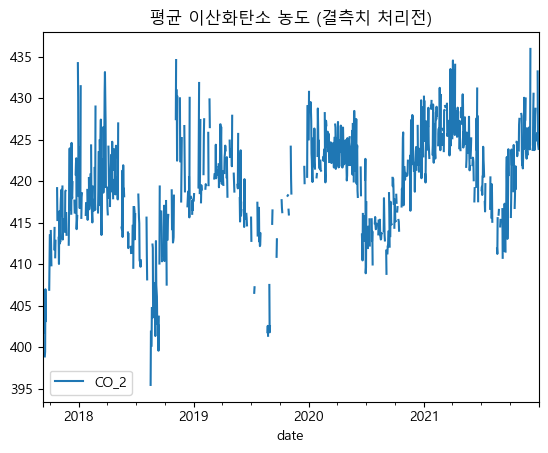

In [12]:
plt.style.use('default')
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='Malgun Gothic'
new_gas[['CO_2']].plot(title='평균 이산화탄소 농도 (결측치 처리전)')
plt.savefig('C:/Users/localadmin/Desktop/src/data preprocessing/Plots/impute1.png')

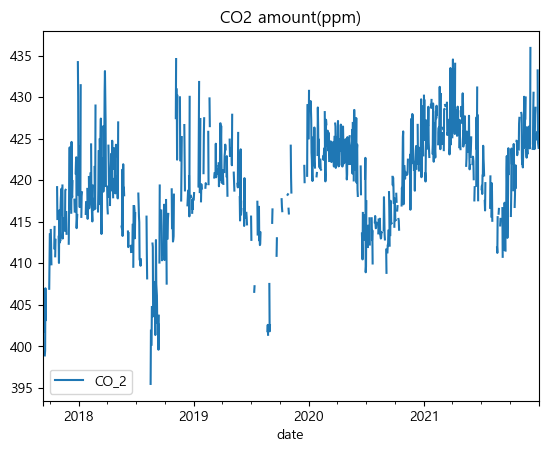

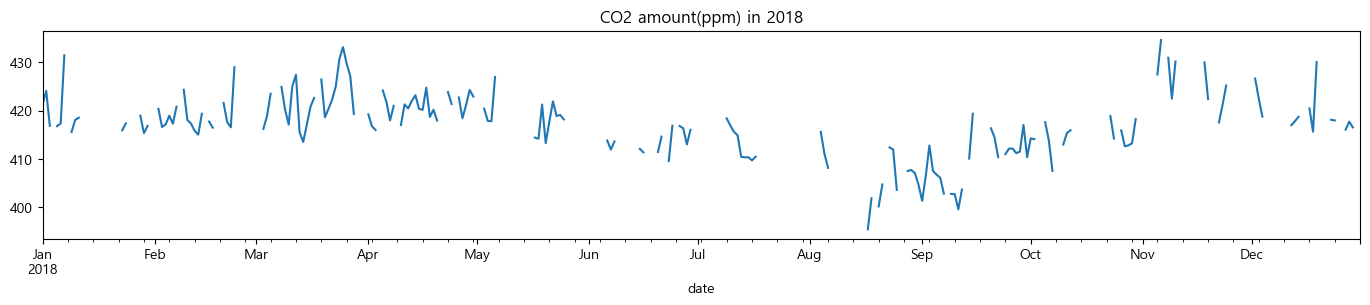

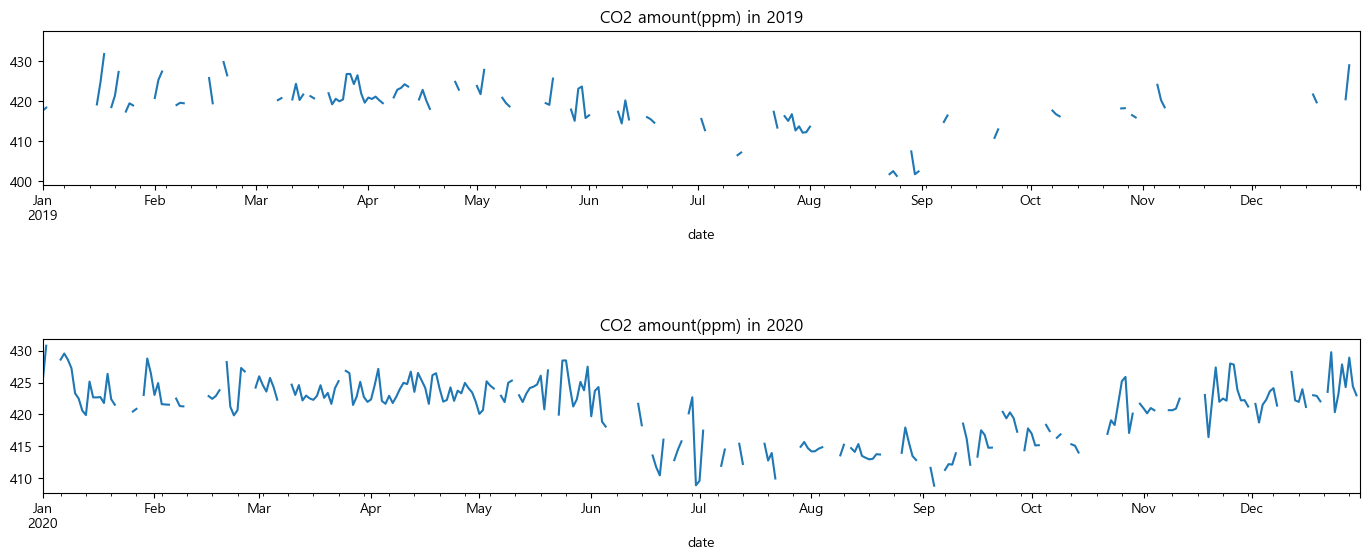

In [13]:
# NA값이 상당히 많다. 
#CO2 이산화탄소
new_gas[['CO_2']].plot(title='CO2 amount(ppm)')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.35)
new_gas.CO_2['2018'].plot(title='CO2 amount(ppm) in 2018')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=1)
new_gas.CO_2['2019'].plot(title='CO2 amount(ppm) in 2019')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=1)
new_gas.CO_2['2020'].plot(title='CO2 amount(ppm) in 2020')
plt.subplots_adjust(hspace=1)

In [14]:
ts_reg_imputation(gas.CO_2)

-----------결측치 발생:  1 번째 값-----------
2 번째 값도 결측치
3 번째 값도 결측치
시작값:  410.98 -> 
 [408.7550198593094, 407.8570623298091, 403.97312235632677] 
 종료값:  403.35
******총  3 개의 결측치 대체 완료***** 

-----------결측치 발생:  6 번째 값-----------
시작값:  401.82 -> 
 [400.7533458264592] 
 종료값:  398.9
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  11 번째 값-----------
12 번째 값도 결측치
13 번째 값도 결측치
14 번째 값도 결측치
15 번째 값도 결측치
시작값:  403.16 -> 
 [404.82680287538284, 405.6585431844354, 408.47047340969334, 409.88643341254834, 409.89384194209646] 
 종료값:  411.89
******총  5 개의 결측치 대체 완료***** 

-----------결측치 발생:  17 번째 값-----------
18 번째 값도 결측치
19 번째 값도 결측치
20 번째 값도 결측치
시작값:  411.89 -> 
 [412.10263806910416, 409.83562427944173, 409.62287691192023, 406.8918449882364] 
 종료값:  406.93
******총  4 개의 결측치 대체 완료***** 

-----------결측치 발생:  24 번째 값-----------
25 번째 값도 결측치
시작값:  413.49 -> 
 [412.69528782588094, 415.19055686386025] 
 종료값:  414.01
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  29 번째 값-----------
30 번째 값도 결측치
31 번째 값도

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\3995676573.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start+j]=nans[j]


시작값:  425.2227783 -> 
 [426.8954209893047] 
 종료값:  426.8319924
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  971 번째 값-----------
시작값:  424.0702887 -> 
 [424.05219881796063] 
 종료값:  422.9294961
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  976 번째 값-----------
시작값:  425.3079101 -> 
 [424.494308729017] 
 종료값:  423.007269
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  986 번째 값-----------
987 번째 값도 결측치
시작값:  426.8996907 -> 
 [424.7656571229969, 421.2839223865746] 
 종료값:  419.9785973
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  1002 번째 값-----------
시작값:  418.1106311 -> 
 [420.1106657683046] 
 종료값:  422.1472961
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  1004 번째 값-----------
1005 번째 값도 결측치
1006 번째 값도 결측치
1007 번째 값도 결측치
시작값:  422.1472961 -> 
 [422.9449859642997, 421.8462717983864, 423.6193832420296, 420.5979960597209] 
 종료값:  420.9843909
******총  4 개의 결측치 대체 완료***** 

-----------결측치 발생:  1009 번째 값-----------
시작값:  420.9843909 -> 
 [422.3571438685364] 
 종료값:  421.6646

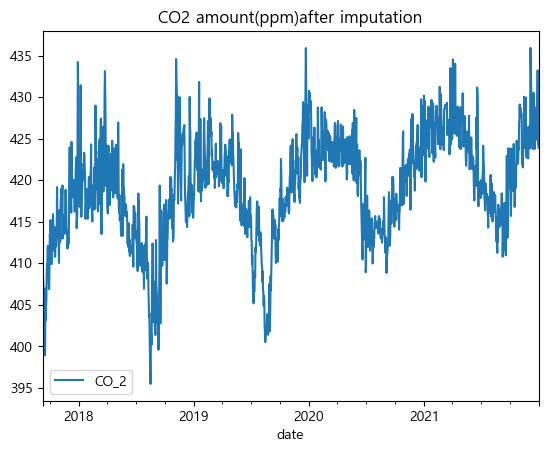

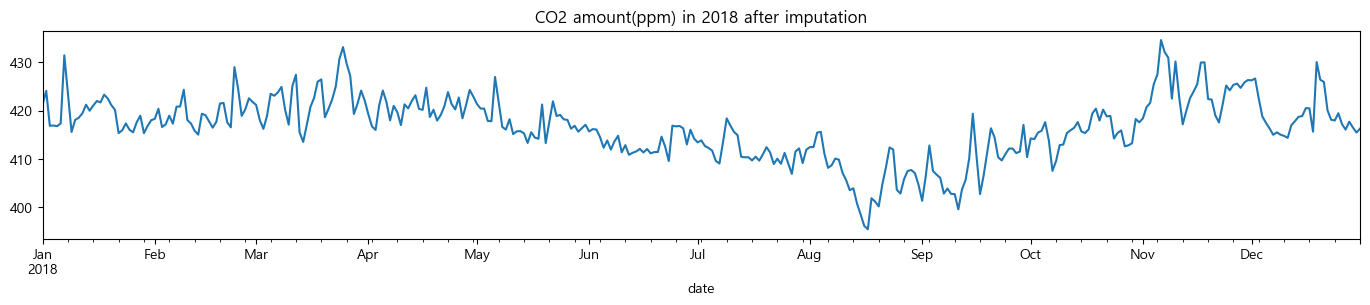

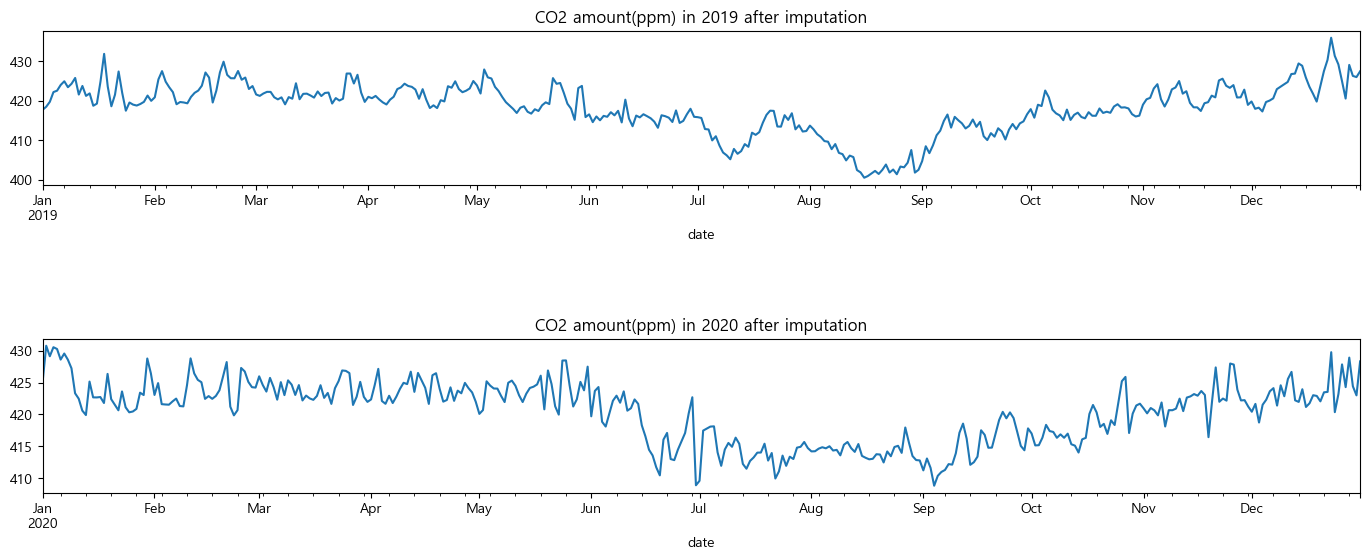

In [16]:
#CO2 이산화탄소 NA값 채운 뒤
new_gas=gas.set_index('date')
new_gas[['CO_2']].plot(title='CO2 amount(ppm)after imputation')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.35)
new_gas.CO_2['2018'].plot(title='CO2 amount(ppm) in 2018 after imputation')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=1)
new_gas.CO_2['2019'].plot(title='CO2 amount(ppm) in 2019 after imputation')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=1)
new_gas.CO_2['2020'].plot(title='CO2 amount(ppm) in 2020 after imputation')
plt.subplots_adjust(hspace=1)

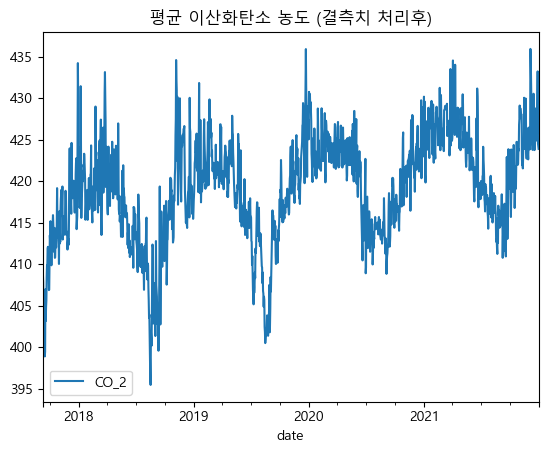

In [18]:
new_gas[['CO_2']].plot(title='평균 이산화탄소 농도 (결측치 처리후)')
plt.savefig('C:/Users/localadmin/Desktop/src/data preprocessing/Plots/impute2.png')

## CH4 메탄가스

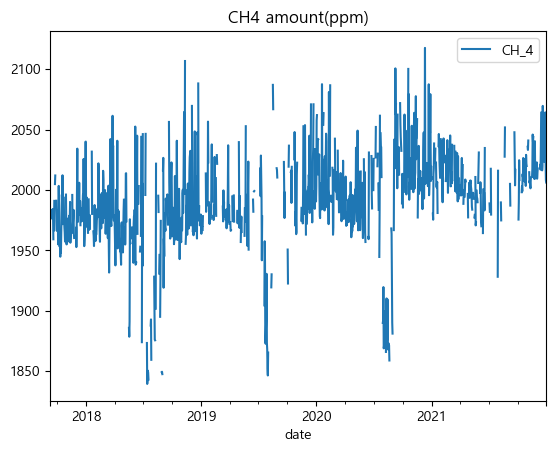

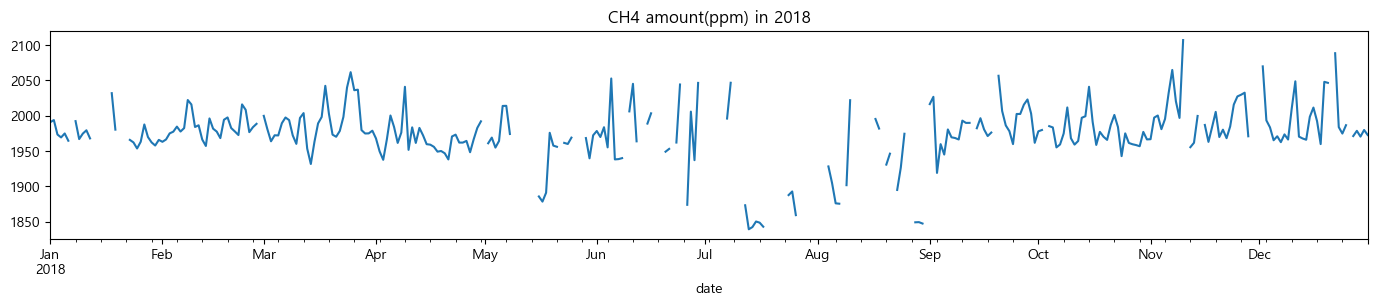

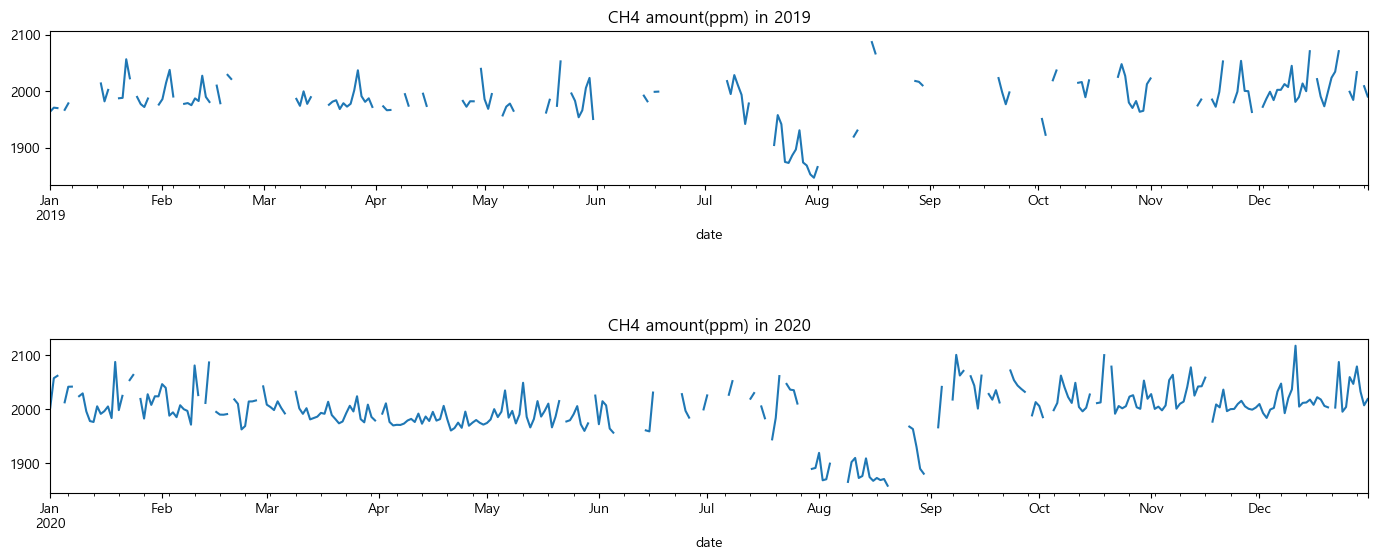

In [19]:
# NA값이 상당히 많다. 
#CH4 메탄가스
new_gas=gas.set_index('date')
new_gas[['CH_4']].plot(title='CH4 amount(ppm)')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.35)
new_gas.CH_4['2018'].plot(title='CH4 amount(ppm) in 2018')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=1)
new_gas.CH_4['2019'].plot(title='CH4 amount(ppm) in 2019')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=1)
new_gas.CH_4['2020'].plot(title='CH4 amount(ppm) in 2020')
plt.subplots_adjust(hspace=1)

In [20]:
ts_reg_imputation(gas.CH_4, 2) #다른 두 지표에 비해 변동의 절대값이 크다. 따라서 시그마 값을 더 크게 준다.

데이터의 첫번째 값이 없어서 전체 평균으로 채우겠습니다. 

-----------결측치 발생:  1 번째 값-----------
2 번째 값도 결측치
3 번째 값도 결측치
시작값:  1991.3509103855977 -> 
 [1988.658222507817, 1988.6195798524168, 1982.6089723090527] 
 종료값:  1983.12
******총  3 개의 결측치 대체 완료***** 

-----------결측치 발생:  6 번째 값-----------
시작값:  1976.51 -> 
 [1980.8316916529184] 
 종료값:  1983.58
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  11 번째 값-----------
시작값:  1959.19 -> 
 [1963.2986057507658] 
 종료값:  1966.56
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  14 번째 값-----------
시작값:  1990.99 -> 
 [1997.1270863688708] 
 종료값:  2004.91
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  17 번째 값-----------
18 번째 값도 결측치
시작값:  2012.04 -> 
 [2006.9609468193867, 1999.912866825097] 
 종료값:  1991.13
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  23 번째 값-----------
시작값:  1983.17 -> 
 [1980.572683884193] 
 종료값:  1980.14
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  30 번째 값-----------
시작값:  1953.78 -> 
 [1955.4692761382084] 
 종료값:  1952.34
******총  1 개

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\3995676573.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[0]=np.mean(df)
C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\3995676573.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start+j]=nans[j]


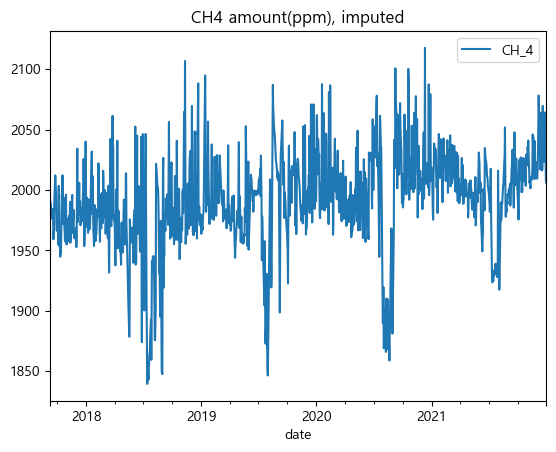

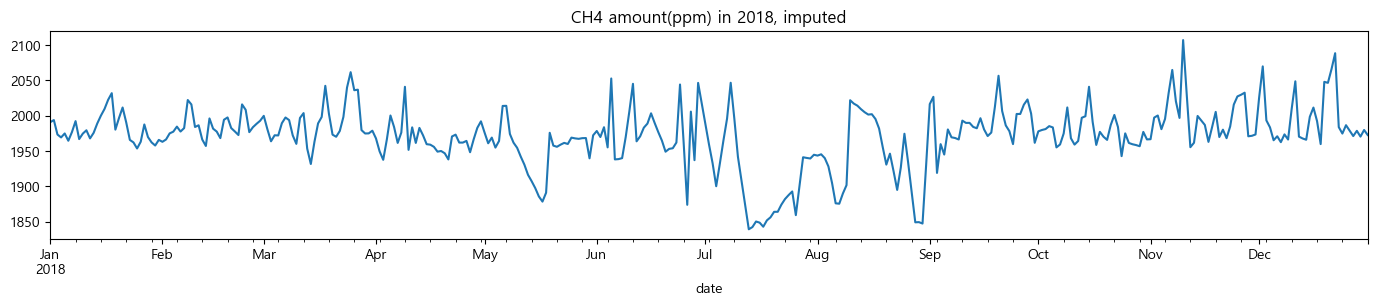

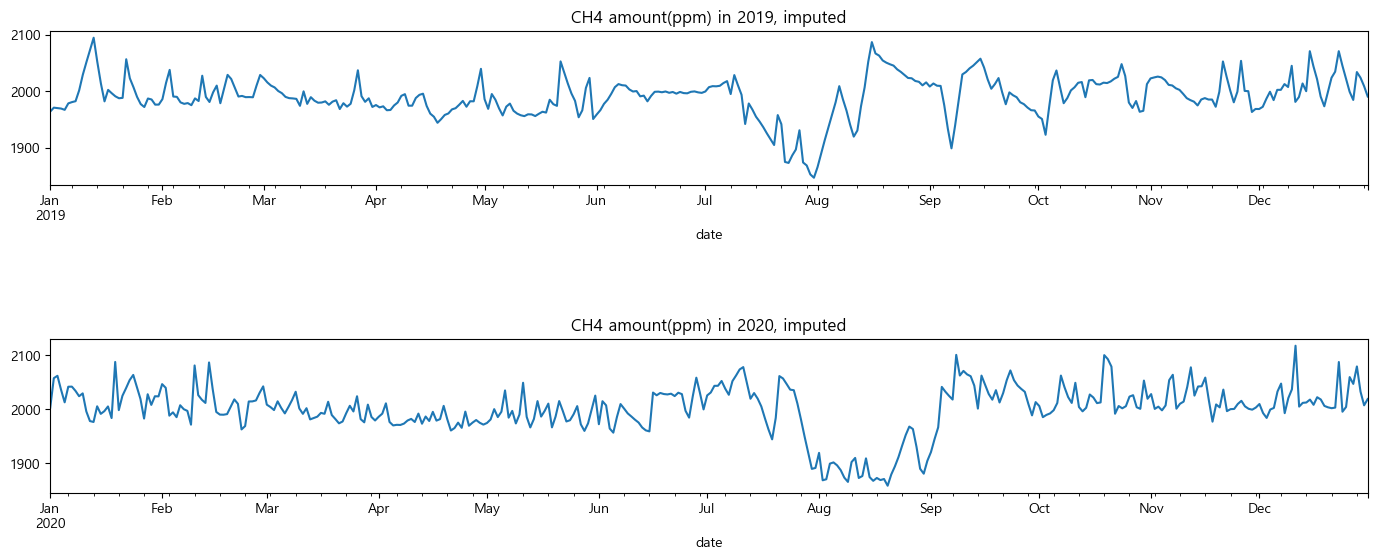

In [21]:
#CH4 메탄가스
#결측치 처리 뒤의 값
new_gas=gas.set_index('date')
new_gas[['CH_4']].plot(title='CH4 amount(ppm), imputed')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.35)
new_gas.CH_4['2018'].plot(title='CH4 amount(ppm) in 2018, imputed')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=1)
new_gas.CH_4['2019'].plot(title='CH4 amount(ppm) in 2019, imputed')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=1)
new_gas.CH_4['2020'].plot(title='CH4 amount(ppm) in 2020, imputed')
plt.subplots_adjust(hspace=1)

## N20 아산화질소

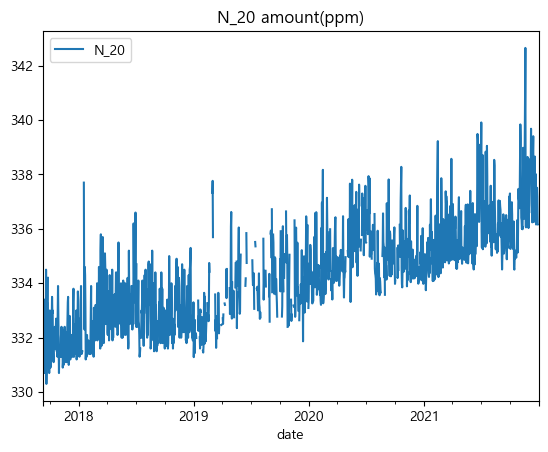

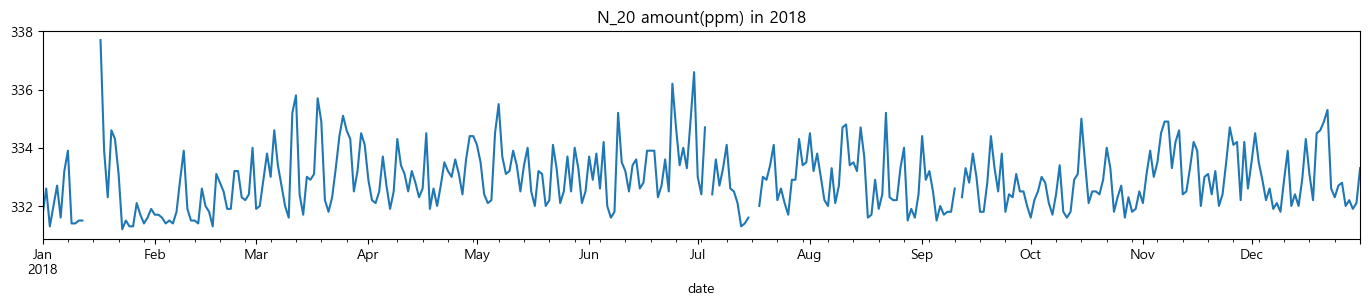

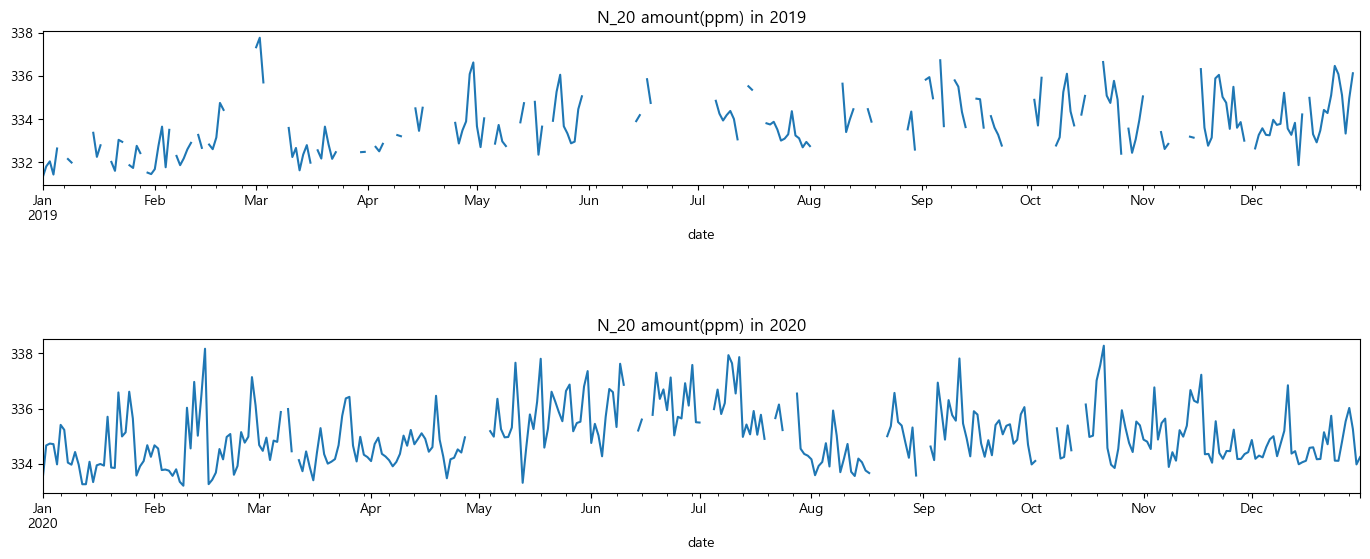

In [22]:
# NA값이 상당히 많다. 
#N20 아산화질소
new_gas=gas.set_index('date')
new_gas[['N_20']].plot(title='N_20 amount(ppm)')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.35)
new_gas.N_20['2018'].plot(title='N_20 amount(ppm) in 2018')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=1)
new_gas.N_20['2019'].plot(title='N_20 amount(ppm) in 2019')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=1)
new_gas.N_20['2020'].plot(title='N_20 amount(ppm) in 2020')
plt.subplots_adjust(hspace=1)

In [23]:
ts_reg_imputation(gas.N_20)

-----------결측치 발생:  2 번째 값-----------
시작값:  334.0 -> 
 [333.03251985930945] 
 종료값:  332.7
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  18 번째 값-----------
시작값:  334.2 -> 
 [333.992062329809] 
 종료값:  332.4
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  127 번째 값-----------
128 번째 값도 결측치
129 번째 값도 결측치
130 번째 값도 결측치
시작값:  331.5 -> 
 [331.4556223563267, 334.37334582645923, 335.4318028753828, 336.0485431844354] 
 종료값:  337.7
******총  4 개의 결측치 대체 완료***** 

-----------결측치 발생:  299 번째 값-----------
시작값:  334.7 -> 
 [334.4954734096933] 
 종료값:  332.4
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  311 번째 값-----------
312 번째 값도 결측치
시작값:  331.6 -> 
 [332.6397667458817, 331.32550860876313] 
 종료값:  332.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  368 번째 값-----------
시작값:  332.6 -> 
 [333.65463806910424] 
 종료값:  332.3
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  485 번째 값-----------
486 번째 값도 결측치
시작값:  332.6377733 -> 
 [332.4049812794417, 333.02181761192026] 
 종료값:  332.1505244

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\3995676573.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start+j]=nans[j]
C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\3995676573.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start+j]=nans[j]


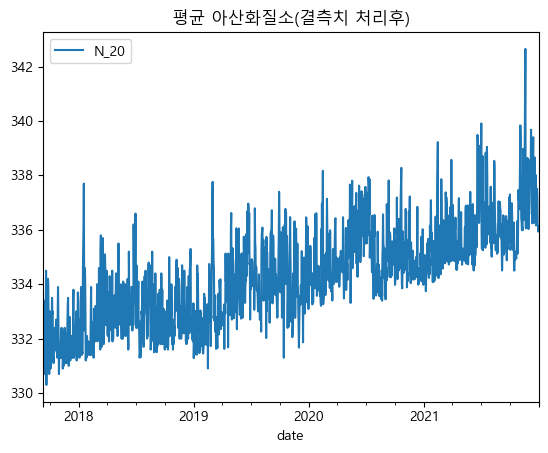

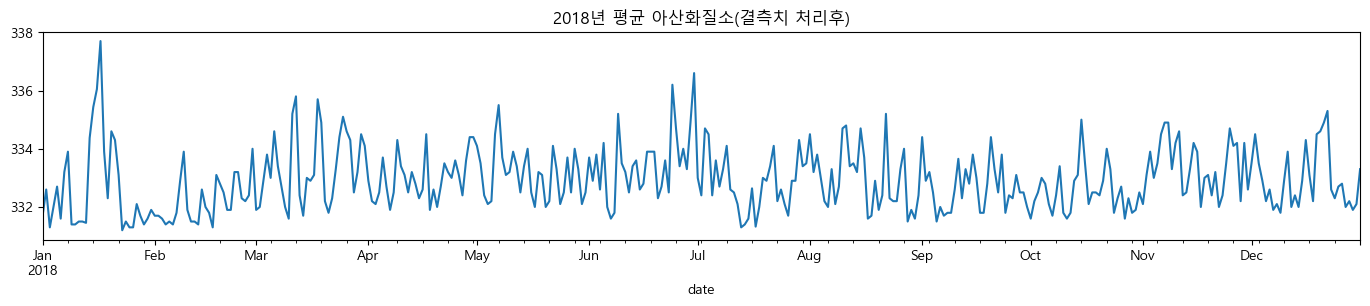

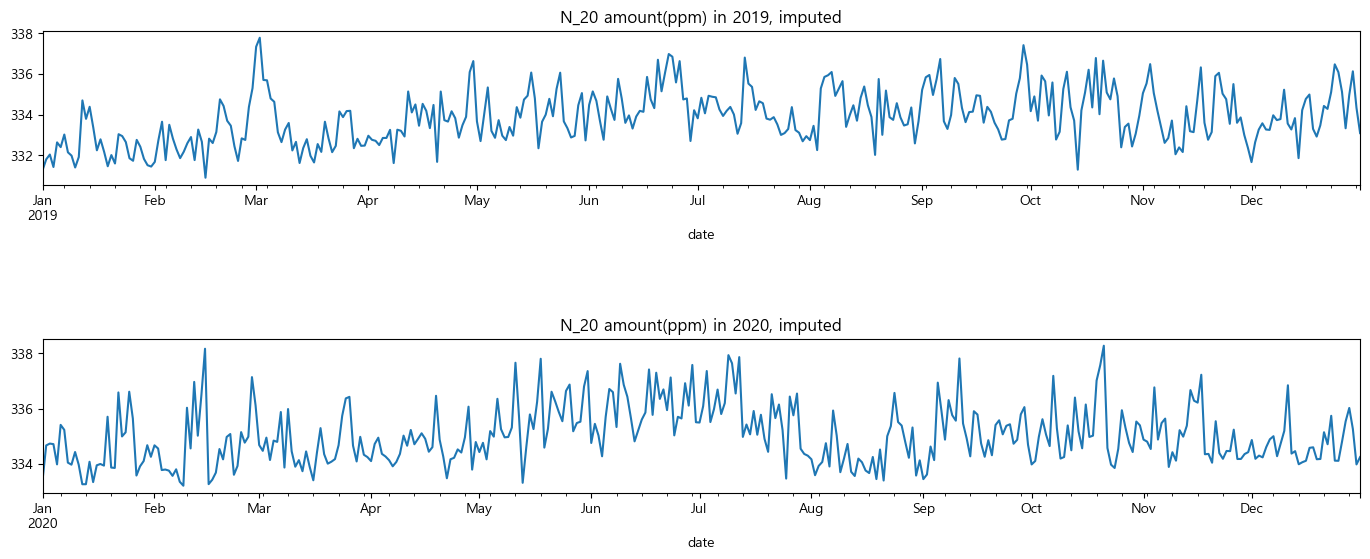

In [24]:
#N20 아산화질소
#결측치 처리 뒤의 값
new_gas=gas.set_index('date')
new_gas[['N_20']].plot(title='평균 아산화질소(결측치 처리후)')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 1)
plt.subplots_adjust(hspace=0.35)
new_gas.N_20['2018'].plot(title='2018년 평균 아산화질소(결측치 처리후)')

plt.figure(figsize=(17,10))
plt.subplot(3, 1, 2)
plt.subplots_adjust(hspace=1)
new_gas.N_20['2019'].plot(title='N_20 amount(ppm) in 2019, imputed')

plt.subplot(3, 1, 3)
plt.subplots_adjust(hspace=1)
new_gas.N_20['2020'].plot(title='N_20 amount(ppm) in 2020, imputed')
plt.subplots_adjust(hspace=1)

In [25]:
gasnew=gas.iloc[:, :4]
gasnew.isnull().sum() 

date    0
CO_2    0
CH_4    0
N_20    0
dtype: int64

In [26]:
gasnew.tail #2017년 9월 8일부터 2021년 12월 31일까지, 총 1576행 확인 완료.

<bound method NDFrame.tail of            date        CO_2         CH_4        N_20
0    2017-09-08  410.980000  1991.350910  334.000000
1    2017-09-09  408.755020  1988.658223  334.000000
2    2017-09-10  407.857062  1988.619580  333.032520
3    2017-09-11  403.973122  1982.608972  332.700000
4    2017-09-12  403.350000  1983.120000  331.100000
...         ...         ...          ...         ...
1571 2021-12-27  429.757783  2038.434192  337.198202
1572 2021-12-28  433.232965  2064.318099  336.188754
1573 2021-12-29  424.571148  2023.425615  336.164348
1574 2021-12-30  424.229515  2008.161220  335.938351
1575 2021-12-31  423.898543  2006.197042  336.020258

[1576 rows x 4 columns]>

In [27]:
gasnew.to_csv("C:/Users/localadmin/Desktop/data/eda data/common features/gas.csv")

### 자외선/(2017.9.8~2021.12.31)
 
_자외선은 일반적으로 자외선A, 자외선B, 자외선C로 나뉘며, 이 중 자외선A와 자외선B는 오존층에 일부가 흡수되고 그 나머지가 지표에 도달합니다._

_지표에 도달하는 자외선은 적은 양이지만 인간과 동·식물에게 큰 피해를 줄 뿐만 아니라 광화학 반응에도 영향을 미치면서 대기 환경을 변화시킵니다._

_기상청은 자외선 복사 중 자외선A(320~400nm)와 자외선B 영역 중 인체에 홍반을 발생시키는 홍반자외선B(280~320 nm)를 관측하고 있습니다._


In [28]:
utray=pd.read_csv("C:/Users/localadmin/Desktop/data/raw data/통일_자외선_날짜정리.csv", encoding='cp949')
utray

,지점,지점명,일시,일최대 자외선 B(W/m2 )
0,132,안면도(감),2017-09-08,0.155
1,132,안면도(감),2017-09-09,0.125
2,132,안면도(감),2017-09-10,0.103
3,132,안면도(감),2017-09-11,0.126
4,132,안면도(감),2017-09-12,0.162
...,...,...,...,...
1571,132,안면도(감),2021-12-27,0.044
1572,132,안면도(감),2021-12-28,0.037
1573,132,안면도(감),2021-12-29,0.037
1574,132,안면도(감),2021-12-30,0.028


In [29]:
utray=utray.iloc[:, 2:]
colname=['date', 'utrayB']
utray.columns=colname
#측정일 datetime 형식으로 바꾸기
date = utray.date
datenew = [dt.datetime.strptime(str(d), '%Y-%m-%d') for d in date ]
utray.date=datenew

In [30]:
utray.isnull().sum()

date       0
utrayB    50
dtype: int64

<AxesSubplot:title={'center':'Ultra layer amount'}>

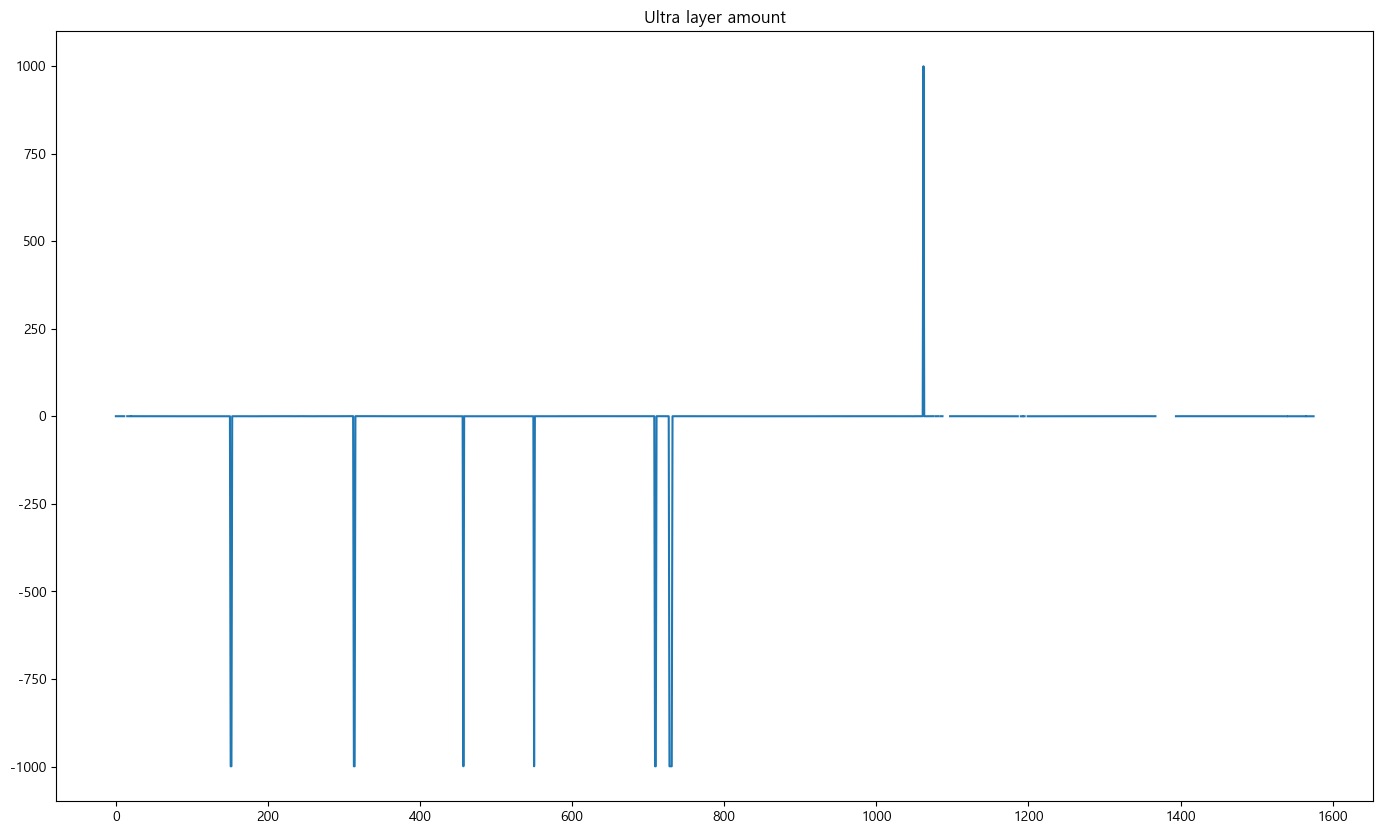

In [31]:
plt.figure(figsize=(17,10))
utray.utrayB.plot(title='Ultra layer amount') #999와 -999는 기계의 결함으로 보인다. 따라서 이 부분도 그냥 np.nan로 치환하고 채운다.

In [32]:
voll=utray.utrayB
for i in range(0, len(utray.utrayB)):
    if np.abs(utray.iloc[i, 1])==999:
        voll[i]=np.nan

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\1150550242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voll[i]=np.nan


In [33]:
print(np.min(voll), np.max(voll))

0.01 0.331


In [34]:
ts_reg_imputation(voll, sigma=0) #utrayB값이 np.random.normal(1, sigma=1)에 의해 본 값보다도 더 크게 변동한다.
#sigma값을 엄청나게 적게 주더라도 기존 값이 0.04처럼 매우 작아서 음수값이 무작위하게 나올 수밖에 없다.
#따라서 white noise를 아예 주지 않기로 한다..

-----------결측치 발생:  12 번째 값-----------
13 번째 값도 결측치
14 번째 값도 결측치
시작값:  0.106 -> 
 [0.1275, 0.149, 0.17049999999999998] 
 종료값:  0.192
******총  3 개의 결측치 대체 완료***** 

-----------결측치 발생:  20 번째 값-----------
시작값:  0.223 -> 
 [0.2145] 
 종료값:  0.206
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  151 번째 값-----------
152 번째 값도 결측치
시작값:  0.063 -> 
 [0.06633333333333333, 0.06966666666666667] 
 종료값:  0.073
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  313 번째 값-----------
314 번째 값도 결측치
시작값:  0.302 -> 
 [0.2946666666666667, 0.28733333333333333] 
 종료값:  0.28
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  457 번째 값-----------
시작값:  0.055 -> 
 [0.057499999999999996] 
 종료값:  0.06
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  550 번째 값-----------
시작값:  0.027 -> 
 [0.0675] 
 종료값:  0.108
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  709 번째 값-----------
710 번째 값도 결측치
시작값:  0.176 -> 
 [0.17633333333333331, 0.17666666666666667] 
 종료값:  0.177
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\3995676573.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start+j]=nans[j]


In [35]:
utray_new=pd.concat([utray.date, voll], axis=1)
utray_new

,date,utrayB
0,2017-09-08,0.155
1,2017-09-09,0.125
2,2017-09-10,0.103
3,2017-09-11,0.126
4,2017-09-12,0.162
...,...,...
1571,2021-12-27,0.044
1572,2021-12-28,0.037
1573,2021-12-29,0.037
1574,2021-12-30,0.028


<AxesSubplot:title={'center':'Ultra layer amount after imputation'}>

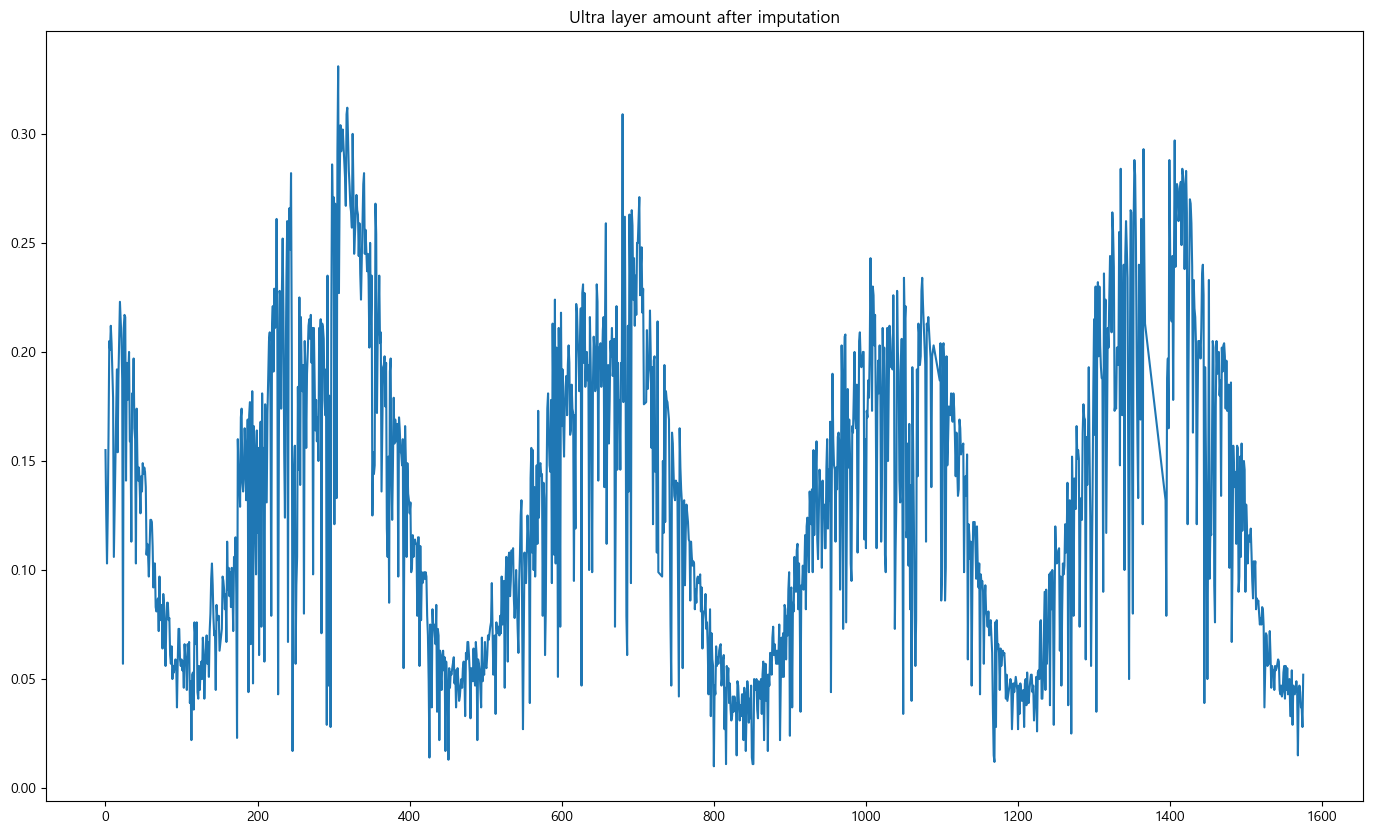

In [36]:
plt.figure(figsize=(17,10))
utray_new.utrayB.plot(title='Ultra layer amount after imputation')

In [37]:
utray_new.tail #2017년 9월 8일부터 2021년 12월 31일까지, 총 1576행 확인 완료

<bound method NDFrame.tail of            date  utrayB
0    2017-09-08   0.155
1    2017-09-09   0.125
2    2017-09-10   0.103
3    2017-09-11   0.126
4    2017-09-12   0.162
...         ...     ...
1571 2021-12-27   0.044
1572 2021-12-28   0.037
1573 2021-12-29   0.037
1574 2021-12-30   0.028
1575 2021-12-31   0.052

[1576 rows x 2 columns]>

In [38]:
utray_new.to_csv("C:/Users/localadmin/Desktop/data/eda data/common features/utray_new.csv")

### 강수산성도(2017.09.10~2021.12.31)
 
_대기 중에 부유하는 오염물질은 비, 눈, 우박 등의 강수나 입자, 가스상 물질로 지면으로 떨어지는데 이런 강하물의 화학성분을 분석하면 대기 중의 강수성분과 오염물질을 감시할 수 있습니다._

_분석된 자료는 강수성분 경향성을 파악하고, 생태계 산성 침적 피해 평가와 원인 규명을 위한 연구 활동에 활용되고 있습니다._
 
_기상청은 세계기상기구(WMO) 지구대기감시(GAW) 프로그램의 일환으로 안면도 기후변화감시소에서 강수 산성도, 전기전도도, 강수이온성분을 관측하고 있습니다._

In [39]:
acid=pd.read_csv("C:/Users/localadmin/Desktop/data/raw data/통일_강수산성도.csv", encoding='cp949')
acid=acid[['일시', '산성도(pH)']]

In [40]:
print(len(dates_nar), acid.shape) #1576일중에서 산성비가 내린 일수는 274일뿐이다.

1576 (274, 2)


In [41]:
acid_new=pd.DataFrame({'date':dates_nar, 
                    'acid(pH)':np.zeros(len(dates_nar))})

In [42]:
#기존 acid 데이터프레임 측정일 datetime 형식으로 바꾸기
acid.columns=['date', 'pH']
date = acid.date
datenew = [dt.datetime.strptime(str(d), '%Y-%m-%d') for d in date ]
acid.date=datenew

In [43]:
#새롭게 만든 데이터 프레임에 산성비 양을 옮겨적는다.
for i in range(0, acid.shape[0]):
    for j in range(0, len(dates_nar)):
        if acid.iloc[i, 0]==acid_new.iloc[j, 0]:
            acid_new.iloc[j, 1]=acid.iloc[i, 1]

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\720219107.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if acid.iloc[i, 0]==acid_new.iloc[j, 0]:


In [44]:
acid_new.isnull().sum()

date        0
acid(pH)    0
dtype: int64

<AxesSubplot:title={'center':'acid rain after imputation'}>

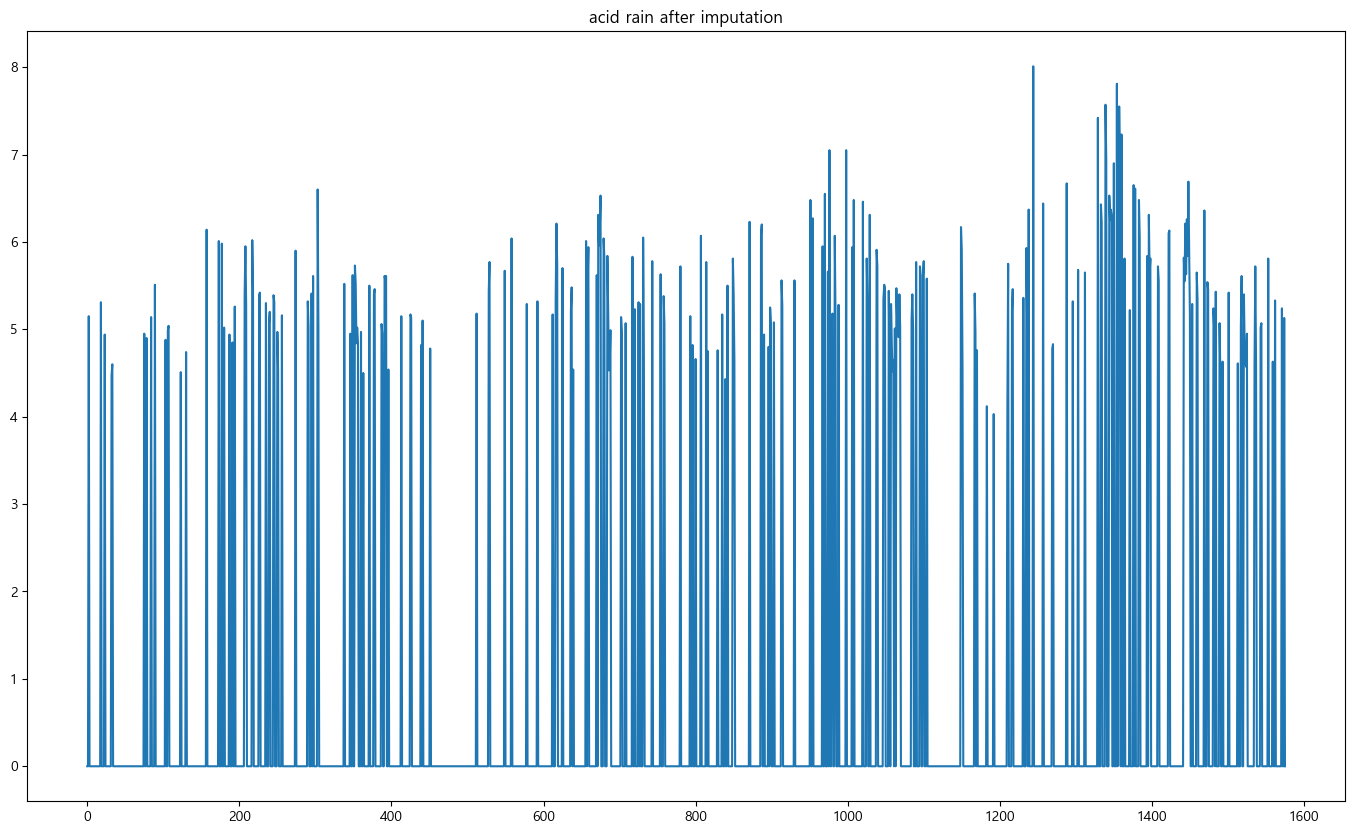

In [46]:
plt.figure(figsize=(17,10))
acid_new.iloc[:, 1].plot(title='acid rain after imputation')

In [47]:
acid_new.tail #2017년 9월 8일부터 2021년 12월 31일까지, 총 1576행 완료.

<bound method NDFrame.tail of             date  acid(pH)
0     2017-09-08      0.00
1     2017-09-09      0.00
2     2017-09-10      5.15
3     2017-09-11      0.00
4     2017-09-12      0.00
...          ...       ...
1571  2021-12-27      5.24
1572  2021-12-28      0.00
1573  2021-12-29      0.00
1574  2021-12-30      5.13
1575  2021-12-31      0.00

[1576 rows x 2 columns]>

In [48]:
acid_new.to_csv("C:/Users/localadmin/Desktop/data/eda data/common features/acid.csv")

## 지역별 데이터 설명
### 1. 황사
_부유분진측정장비(PM10)를 이용하여 미세먼지 등 대기 중에 부유하는 에어로졸 중 직경이 10㎛ 이하인 입자의 농도를 관측한 자료로, 황사 관측의 참고자료로 활용되고 있습니다._


In [49]:
#황사
dust=pd.read_csv("C:/Users/localadmin/Desktop/data/raw data/부유분진_전국.csv", encoding='cp949')

In [50]:
colname=['location', 'loc_name', 'date', 'dustperday']
dust.columns=colname
date=dust.date 
datenew=[dt.datetime.strptime(str(d), '%Y-%m-%d') for d in date]
dust.date=datenew

In [51]:
#관측소 넘버 문자열로 바꾸기
lst=[str(d) for d in dust.location]

In [52]:
dust.location=lst

In [53]:
#실제로 내가 추출한 기간에 있는 관측소 넘버들 확인
exist=dust.groupby('location').count().index

In [54]:
dust.groupby('location').count()

,loc_name,date,dustperday
location,,,
100,1412,1412,1412
102,1686,1686,1686
108,1676,1676,1676
115,1609,1609,1609
116,1405,1405,1405
119,1772,1772,1772
121,1704,1704,1704
130,1602,1602,1602
132,1771,1771,1771


In [55]:
exist

Index(['100', '102', '108', '115', '116', '119', '121', '130', '132', '135',
       '136', '140', '143', '146', '152', '156', '160', '169', '185', '192',
       '201', '229', '232', '268', '273', '501', '90', '93', '94'],
      dtype='object', name='location')

# 최종 지역 분류 (19개)
### 괄호가 종합관측소이고 굵은 글씨가 부유분진 기준관측소
종합 관측소 중 부유분진 관측을 하지 않는 곳은 인접 지역의 부유분진 기준 관측소 값을 활용했다.
 
* **강원도**
- 삼척시(214), 강릉시(105), 동해시(106), 정선군(217), 태백시(216): 강원1 **영월(121)+대관령(100)**
- 홍천군(212), 인제군(211), 평창군(-), 횡성군(-), 원주시(114): 강원2 **영월(121)+대관령(100)**
- 화천군(-), 양구군(-), 춘천시(101): 강원3 **속초(90)+북춘천(93)**
 <br>

* **경기도**
- 양평군(202), 가평군, 남양주시: 경기1 **서울(108)+수원(119)**
- 이천시(203), 안성시, 여주시, 성남시: 경기2 **수원(119)+강화(201)**
- 고양시, 연천군, 파주시(99): 경기3 **강화(201)+백령도(102)**

* **경상북도**
- 영덕군(**277**), 김천시(-), 문경시(**273**), 상주시(137), 영주시(272), 청송군(276), 봉화군(271), 안동시(**136**), 의성군(278), 영천시(281), 영양군(-), 예천군(-):경북1
- 포항시(138), 경주시(283): 경북2 **문경(273)+대구(143)**
<br>
* **경상남도**
- 산청군(289), 진주시(**192**), 합천군(285), 하동군(-), 의령군(263), 함양군(264), 거창군(284):경남1
- 창원시(155), 함안군(-), 김해시(253): 경남2 **진주(192)**
<br>
* **전라남도**
- 보성군(258), 순천시(174), 곡성군(-), 구례군(-), 화순군(-), 고흥군(262), 광양시(266), 함평군(-)(보성군, 곡성군): 전남1 **광주(156)**
- 완도군(170):전남2 **진도(268)**
<br>
* **전라북도**(임실군, 남원시)
- 전체를 하나로 본다.(172, 251, 140, 247, 243, 254, 244, 248, **146**, 245)
<br>
* **충청남도**(천안시)
- 하나로 본다.(238, 235, 236, 129, **232**, 177)
<br>
* **충청북도** (충추시) 
- 하나로 본다. (226, 221, 131, **135**, 127)
<br>
* **제주특별자치시**(**185**, 189, 187, 188, 265, 184)

In [56]:
idx1=[d in ['121', '100'] for d in dust['location'].tolist()]
idx2=[d in ['121', '100'] for d in dust['location'].tolist()]
idx3=[d in ['90', '93'] for d in dust['location'].tolist()]
dust_gwon_1=dust[idx1]
dust_gwon_2=dust[idx2]
dust_gwon_3=dust[idx3]

idx1=[d in ['108', '119'] for d in dust['location'].tolist()]
idx2=[d in ['119', '201'] for d in dust['location'].tolist()]
idx3=[d in ['201', '102'] for d in dust['location'].tolist()]
dust_ggi_1=dust[idx1]
dust_ggi_2=dust[idx2]
dust_ggi_3=dust[idx3]

idx1=[d in ['277', '273', '137', '272', '276', '271', '136', '278', '281'] for d in dust['location'].tolist()]
idx2=[d in ['273', '143'] for d in dust['location'].tolist()]
dust_gsangbuk_1=dust[idx1]
dust_gsangbuk_2=dust[idx2]


idx1=[d in ['192'] for d in dust['location'].tolist()]
dust_gsangnam_1=dust[idx1]
dust_gsangnam_2=dust[idx1]


idx1=[d in ['156'] for d in dust['location'].tolist()]
idx2=[d in ['268'] for d in dust['location'].tolist()]
dust_jnam_1=dust[idx1]
dust_jnam_2=dust[idx2]


idx1=[d in ['172', '251', '140', '247', '243', '254', '244', '248', '146', '245'] for d in dust['location'].tolist()]
dust_jbuk_1=dust[idx1]


idx1=[d in ['238', '235', '236', '129', '232', '177'] for d in dust['location'].tolist()]
dust_ccnam_1=dust[idx1]


idx1=[d in ['226', '221', '131', '135', '127'] for d in dust['location'].tolist()]
dust_ccbuk_1=dust[idx1]

idx1=[d in ['185', '189', '187', '188', '265', '184'] for d in dust['location'].tolist()]
dust_jeju_1=dust[idx1]

In [57]:
# 지역별 데이터 프레임 행이 1850개일거라는 보장은 없다.
#미리 날짜 데이터 프레임을 만든다.
date_frame=pd.DataFrame({'date': dates, 'nomean':np.zeros(len(dates))})
date_frame=date_frame.set_index('date')


def datetest(df):
    df=df[['dustperday', 'date']].groupby(date).mean()
    idx=[datetime.strptime(d, "%Y-%m-%d") for d in df.index]
    df.index=[dd.date() for dd in idx]
    df_full=date_frame.join(df, how='left')
    df_full=df_full[['dustperday']]
    print(df_full.isnull().sum())
    return df_full

In [58]:
#강원1
dust_gwon_1_full=datetest(dust_gwon_1)

dustperday    116
dtype: int64


In [59]:
ts_reg_imputation(dust_gwon_1_full.dustperday)

-----------결측치 발생:  9 번째 값-----------
시작값:  8.0 -> 
 [11.682519859309425] 
 종료값:  16.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  25 번째 값-----------
시작값:  8.0 -> 
 [8.94206232980904] 
 종료값:  8.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  29 번째 값-----------
시작값:  7.0 -> 
 [7.2156223563266915] 
 종료값:  10.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  73 번째 값-----------
74 번째 값도 결측치
시작값:  13.0 -> 
 [19.8933458264592, 26.21180287538284] 
 종료값:  32.5
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  173 번째 값-----------
시작값:  54.0 -> 
 [40.5885431844354] 
 종료값:  28.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  19.5 -> 
 [20.19547340969337] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  194 번째 값-----------
시작값:  15.0 -> 
 [16.906433412548353] 
 종료값:  17.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  208 번째 값-----------
시작값:  71.0 -> 
 [38.45884194209644] 
 종료값:  7.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:

In [60]:
#강원2
dust_gwon_2_full=datetest(dust_gwon_2)

dustperday    116
dtype: int64


In [61]:
ts_reg_imputation(dust_gwon_2_full.dustperday)

-----------결측치 발생:  9 번째 값-----------
시작값:  8.0 -> 
 [11.682519859309425] 
 종료값:  16.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  25 번째 값-----------
시작값:  8.0 -> 
 [8.94206232980904] 
 종료값:  8.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  29 번째 값-----------
시작값:  7.0 -> 
 [7.2156223563266915] 
 종료값:  10.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  73 번째 값-----------
74 번째 값도 결측치
시작값:  13.0 -> 
 [19.8933458264592, 26.21180287538284] 
 종료값:  32.5
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  173 번째 값-----------
시작값:  54.0 -> 
 [40.5885431844354] 
 종료값:  28.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  19.5 -> 
 [20.19547340969337] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  194 번째 값-----------
시작값:  15.0 -> 
 [16.906433412548353] 
 종료값:  17.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  208 번째 값-----------
시작값:  71.0 -> 
 [38.45884194209644] 
 종료값:  7.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:

<AxesSubplot:xlabel='date'>

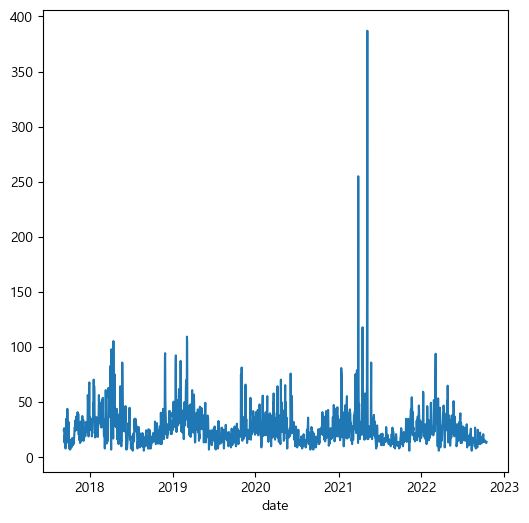

In [62]:
plt.figure(figsize=(6,6))
dust_gwon_2_full.dustperday.plot()

In [63]:
#강원3
dust_gwon_3_full=datetest(dust_gwon_3)

dustperday    29
dtype: int64


In [64]:
ts_reg_imputation(dust_gwon_3_full.dustperday)

-----------결측치 발생:  251 번째 값-----------
252 번째 값도 결측치
시작값:  37.0 -> 
 [29.349186525976094, 23.025395663142376] 
 종료값:  15.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  355 번째 값-----------
시작값:  14.5 -> 
 [12.465622356326692] 
 종료값:  13.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  385 번째 값-----------
시작값:  9.0 -> 
 [11.643345826459202] 
 종료값:  13.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  393 번째 값-----------
시작값:  9.5 -> 
 [17.46180287538284] 
 종료값:  25.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  579 번째 값-----------
시작값:  18.5 -> 
 [18.5885431844354] 
 종료값:  19.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  727 번째 값-----------
시작값:  8.5 -> 
 [10.195473409693372] 
 종료값:  10.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  760 번째 값-----------
761 번째 값도 결측치
시작값:  11.5 -> 
 [15.573100079215017, 17.292175275429774] 
 종료값:  21.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  984 번째 값-----------
985 번째 값도 결측치
시작값:  10.0 -> 
 [14.371304735770883, 

In [65]:
# 경기1
dust_ggi_1_full=datetest(dust_ggi_1)

dustperday    39
dtype: int64


In [66]:
ts_reg_imputation(dust_ggi_1_full.dustperday)

-----------결측치 발생:  173 번째 값-----------
시작값:  85.5 -> 
 [60.43251985930942] 
 종료값:  36.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  26.0 -> 
 [28.19206232980904] 
 종료값:  29.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  189 번째 값-----------
시작값:  15.5 -> 
 [20.46562235632669] 
 종료값:  28.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  208 번째 값-----------
209 번째 값도 결측치
시작값:  60.5 -> 
 [78.56001249312587, 96.04513620871619] 
 종료값:  113.5
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  227 번째 값-----------
시작값:  31.0 -> 
 [21.0885431844354] 
 종료값:  12.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  243 번째 값-----------
시작값:  25.0 -> 
 [31.94547340969337] 
 종료값:  37.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  250 번째 값-----------
251 번째 값도 결측치
252 번째 값도 결측치
253 번째 값도 결측치
254 번째 값도 결측치
시작값:  60.0 -> 
 [55.90643341254835, 49.45884194209644, 46.20463806910421, 39.92962427944175, 35.708876911920264] 
 종료값:  30.0
******총  5 개의 결측치 대체 완료**

In [67]:
dust_ggi_2_full=datetest(dust_ggi_2)

dustperday    16
dtype: int64


In [68]:
ts_reg_imputation(dust_ggi_2_full.dustperday)

-----------결측치 발생:  33 번째 값-----------
시작값:  33.0 -> 
 [25.932519859309426] 
 종료값:  19.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  24.5 -> 
 [27.44206232980904] 
 종료값:  29.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  208 번째 값-----------
209 번째 값도 결측치
시작값:  51.0 -> 
 [71.04895568966002, 94.06001249312585] 
 종료값:  115.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  236 번째 값-----------
시작값:  45.5 -> 
 [40.96180287538284] 
 종료값:  36.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  302 번째 값-----------
시작값:  8.0 -> 
 [10.5885431844354] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  349 번째 값-----------
시작값:  27.5 -> 
 [18.19547340969337] 
 종료값:  7.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  384 번째 값-----------
시작값:  12.0 -> 
 [17.906433412548353] 
 종료값:  22.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  393 번째 값-----------
시작값:  8.5 -> 
 [17.70884194209644] 
 종료값:  28.0
******총  1 개의 결측치 대체 완료***** 

---------

In [69]:
dust_ggi_3_full=datetest(dust_ggi_3)

dustperday    31
dtype: int64


In [70]:
ts_reg_imputation(dust_ggi_3_full.dustperday)

-----------결측치 발생:  33 번째 값-----------
시작값:  21.0 -> 
 [18.932519859309426] 
 종료값:  17.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  66 번째 값-----------
67 번째 값도 결측치
68 번째 값도 결측치
69 번째 값도 결측치
70 번째 값도 결측치
71 번째 값도 결측치
72 번째 값도 결측치
73 번째 값도 결측치
74 번째 값도 결측치
75 번째 값도 결측치
시작값:  24.0 -> 
 [24.510244147990857, 22.351985992690327, 23.847891281004653, 23.484530148110114, 22.67945227534449, 23.85456431878428, 23.63370613982108, 22.004296487550988, 23.56827443274058, 22.111442461259923] 
 종료값:  22.0
******총  10 개의 결측치 대체 완료***** 

-----------결측치 발생:  87 번째 값-----------
시작값:  63.0 -> 
 [42.708876911920264] 
 종료값:  21.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  96 번째 값-----------
시작값:  30.0 -> 
 [36.46984498823642] 
 종료값:  45.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  293 번째 값-----------
시작값:  13.0 -> 
 [13.53195449254759] 
 종료값:  16.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  308 번째 값-----------
시작값:  17.0 -> 
 [17.353890197193635] 
 종료값:  15.0
******총  1 개의 결측치

In [71]:
#경상북도
dust_gsangbuk_1_full=datetest(dust_gsangbuk_1)

dustperday    29
dtype: int64


In [72]:
ts_reg_imputation(dust_gsangbuk_1_full.dustperday)

-----------결측치 발생:  178 번째 값-----------
시작값:  33.0 -> 
 [26.182519859309426] 
 종료값:  20.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  227 번째 값-----------
228 번째 값도 결측치
시작값:  38.5 -> 
 [34.025395663142376, 26.882289022993355] 
 종료값:  23.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  275 번째 값-----------
276 번째 값도 결측치
시작값:  24.0 -> 
 [21.3933458264592, 18.21180287538284] 
 종료값:  15.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  297 번째 값-----------
시작값:  12.0 -> 
 [11.5885431844354] 
 종료값:  12.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  301 번째 값-----------
시작값:  13.0 -> 
 [11.945473409693372] 
 종료값:  9.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  304 번째 값-----------
시작값:  14.0 -> 
 [18.906433412548353] 
 종료값:  22.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  336 번째 값-----------
시작값:  18.0 -> 
 [12.45884194209644] 
 종료값:  8.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  392 번째 값-----------
393 번째 값도 결측치
시작값:  16.0 -> 
 [19.371304735770885, 20

In [73]:
dust_gsangbuk_2_full=datetest(dust_gsangbuk_2)

dustperday    21
dtype: int64


In [74]:
ts_reg_imputation(dust_gsangbuk_2_full.dustperday)

-----------결측치 발생:  34 번째 값-----------
시작값:  26.0 -> 
 [21.682519859309426] 
 종료값:  18.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  38 번째 값-----------
시작값:  23.0 -> 
 [23.69206232980904] 
 종료값:  23.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  35.0 -> 
 [26.71562235632669] 
 종료값:  21.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  299 번째 값-----------
시작값:  12.0 -> 
 [13.393345826459202] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  393 번째 값-----------
시작값:  7.0 -> 
 [15.21180287538284] 
 종료값:  23.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  579 번째 값-----------
시작값:  17.5 -> 
 [15.8385431844354] 
 종료값:  15.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  744 번째 값-----------
시작값:  11.5 -> 
 [11.695473409693372] 
 종료값:  10.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  760 번째 값-----------
761 번째 값도 결측치
시작값:  11.5 -> 
 [15.073100079215017, 16.292175275429774] 
 종료값:  19.5
******총  2 개의 결측치 대체 완료***** 

------

In [75]:
#경상남도
dust_gsangnam_1_full=datetest(dust_gsangnam_1)

dustperday    106
dtype: int64


In [76]:
ts_reg_imputation(dust_gsangnam_1_full.dustperday)

-----------결측치 발생:  83 번째 값-----------
84 번째 값도 결측치
시작값:  39.0 -> 
 [33.01585319264276, 28.358728996475705] 
 종료값:  22.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  29.0 -> 
 [22.71562235632669] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  181 번째 값-----------
시작값:  22.0 -> 
 [24.3933458264592] 
 종료값:  26.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  187 번째 값-----------
시작값:  27.0 -> 
 [20.71180287538284] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  189 번째 값-----------
시작값:  14.0 -> 
 [16.0885431844354] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  192 번째 값-----------
시작값:  19.0 -> 
 [17.94547340969337] 
 종료값:  15.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  194 번째 값-----------
시작값:  15.0 -> 
 [15.40643341254835] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  227 번째 값-----------
228 번째 값도 결측치
시작값:  41.0 -> 
 [33.125508608763106, 27.537971402437552] 
 종료값:  19.0
******

In [77]:
dust_gsangnam_2_full=datetest(dust_gsangnam_2)

dustperday    106
dtype: int64


In [78]:
ts_reg_imputation(dust_gsangnam_2_full.dustperday)

-----------결측치 발생:  83 번째 값-----------
84 번째 값도 결측치
시작값:  39.0 -> 
 [33.01585319264276, 28.358728996475705] 
 종료값:  22.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  29.0 -> 
 [22.71562235632669] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  181 번째 값-----------
시작값:  22.0 -> 
 [24.3933458264592] 
 종료값:  26.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  187 번째 값-----------
시작값:  27.0 -> 
 [20.71180287538284] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  189 번째 값-----------
시작값:  14.0 -> 
 [16.0885431844354] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  192 번째 값-----------
시작값:  19.0 -> 
 [17.94547340969337] 
 종료값:  15.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  194 번째 값-----------
시작값:  15.0 -> 
 [15.40643341254835] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  227 번째 값-----------
228 번째 값도 결측치
시작값:  41.0 -> 
 [33.125508608763106, 27.537971402437552] 
 종료값:  19.0
******

In [79]:
#전라북도
dust_jbuk_1_full=datetest(dust_jbuk_1)

dustperday    23
dtype: int64


In [80]:
ts_reg_imputation(dust_jbuk_1_full.dustperday)

-----------결측치 발생:  173 번째 값-----------
시작값:  47.5 -> 
 [42.43251985930942] 
 종료값:  38.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
179 번째 값도 결측치
시작값:  28.5 -> 
 [28.525395663142373, 25.88228902299336] 
 종료값:  26.5
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  181 번째 값-----------
시작값:  26.5 -> 
 [43.8933458264592] 
 종료값:  60.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  209 번째 값-----------
시작값:  18.0 -> 
 [49.46180287538284] 
 종료값:  80.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  296 번째 값-----------
시작값:  13.5 -> 
 [11.0885431844354] 
 종료값:  9.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  393 번째 값-----------
시작값:  9.0 -> 
 [17.19547340969337] 
 종료값:  23.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  744 번째 값-----------
시작값:  11.0 -> 
 [12.40643341254835] 
 종료값:  12.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  760 번째 값-----------
761 번째 값도 결측치
시작값:  13.0 -> 
 [16.12550860876311, 21.53797140243755] 
 종료값:  24.0
******총 

In [81]:
dust_jnam_1_full=datetest(dust_jnam_1)

dustperday    194
dtype: int64


In [82]:
ts_reg_imputation(dust_jnam_1_full.dustperday)

-----------결측치 발생:  3 번째 값-----------
시작값:  35.0 -> 
 [29.682519859309426] 
 종료값:  25.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  44 번째 값-----------
시작값:  24.0 -> 
 [24.69206232980904] 
 종료값:  24.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  107 번째 값-----------
시작값:  50.0 -> 
 [35.71562235632669] 
 종료값:  24.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  173 번째 값-----------
시작값:  55.0 -> 
 [44.3933458264592] 
 종료값:  33.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  20.0 -> 
 [19.71180287538284] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  192 번째 값-----------
시작값:  26.0 -> 
 [18.5885431844354] 
 종료값:  12.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  194 번째 값-----------
시작값:  12.0 -> 
 [15.445473409693372] 
 종료값:  17.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  218 번째 값-----------
시작값:  27.0 -> 
 [68.90643341254835] 
 종료값:  109.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  227 번째 값-----------
22

In [83]:
dust_jnam_2_full=datetest(dust_jnam_2)

dustperday    115
dtype: int64


In [84]:
ts_reg_imputation(dust_jnam_2_full.dustperday)

-----------결측치 발생:  13 번째 값-----------
14 번째 값도 결측치
시작값:  32.0 -> 
 [28.682519859309426, 26.69206232980904] 
 종료값:  23.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  28 번째 값-----------
시작값:  14.0 -> 
 [12.715622356326692] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  60 번째 값-----------
시작값:  26.0 -> 
 [41.3933458264592] 
 종료값:  56.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  118 번째 값-----------
시작값:  19.0 -> 
 [20.21180287538284] 
 종료값:  21.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  133 번째 값-----------
134 번째 값도 결측치
135 번째 값도 결측치
136 번째 값도 결측치
시작값:  90.0 -> 
 [76.9885431844354, 65.74547340969337, 53.106433412548355, 39.05884194209644] 
 종료값:  27.0
******총  4 개의 결측치 대체 완료***** 

-----------결측치 발생:  194 번째 값-----------
시작값:  14.0 -> 
 [15.204638069104217] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  200 번째 값-----------
시작값:  48.0 -> 
 [39.92962427944175] 
 종료값:  32.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  228 번째 값--

In [85]:
#충청남도 충청북도
dust_ccnam_1_full=datetest(dust_ccnam_1)

dustperday    166
dtype: int64


In [86]:
ts_reg_imputation(dust_ccnam_1_full.dustperday)

-----------결측치 발생:  141 번째 값-----------
142 번째 값도 결측치
시작값:  31.0 -> 
 [35.68251985930942, 41.69206232980904] 
 종료값:  46.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  152 번째 값-----------
시작값:  30.0 -> 
 [40.21562235632669] 
 종료값:  53.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  173 번째 값-----------
시작값:  76.0 -> 
 [58.8933458264592] 
 종료값:  41.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  31.0 -> 
 [29.71180287538284] 
 종료값:  28.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  181 번째 값-----------
시작값:  26.0 -> 
 [42.5885431844354] 
 종료값:  60.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  209 번째 값-----------
시작값:  18.0 -> 
 [52.94547340969337] 
 종료값:  86.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  228 번째 값-----------
시작값:  16.0 -> 
 [28.906433412548353] 
 종료값:  40.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  243 번째 값-----------
시작값:  22.0 -> 
 [30.45884194209644] 
 종료값:  40.0
******총  1 개의 결측치 대체 완료***** 

--------

In [87]:
dust_ccbuk_1_full=datetest(dust_ccbuk_1)

dustperday    329
dtype: int64


In [88]:
ts_reg_imputation(dust_ccbuk_1_full.dustperday)

-----------결측치 발생:  38 번째 값-----------
39 번째 값도 결측치
시작값:  15.0 -> 
 [15.34918652597609, 17.025395663142373] 
 종료값:  17.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  42 번째 값-----------
시작값:  16.0 -> 
 [13.715622356326692] 
 종료값:  14.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  178 번째 값-----------
시작값:  27.0 -> 
 [23.3933458264592] 
 종료값:  19.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  192 번째 값-----------
시작값:  33.0 -> 
 [22.21180287538284] 
 종료값:  11.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  208 번째 값-----------
시작값:  45.0 -> 
 [26.0885431844354] 
 종료값:  8.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  227 번째 값-----------
228 번째 값도 결측치
시작값:  30.0 -> 
 [27.278806743026703, 23.573100079215017] 
 종료값:  19.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  253 번째 값-----------
254 번째 값도 결측치
시작값:  9.0 -> 
 [10.45884194209644, 14.204638069104217] 
 종료값:  15.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  267 번째 값-----------
268 번째 값도 결측치
시작값:  37.

In [89]:
#제주도
dust_jeju_1_full=datetest(dust_jeju_1)

dustperday    423
dtype: int64


In [90]:
ts_reg_imputation(dust_jeju_1_full.dustperday)

-----------결측치 발생:  3 번째 값-----------
시작값:  26.0 -> 
 [27.182519859309426] 
 종료값:  29.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  5 번째 값-----------
시작값:  29.0 -> 
 [28.69206232980904] 
 종료값:  27.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  10 번째 값-----------
시작값:  16.0 -> 
 [36.71562235632669] 
 종료값:  60.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  13 번째 값-----------
시작값:  40.0 -> 
 [36.8933458264592] 
 종료값:  33.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  19 번째 값-----------
시작값:  30.0 -> 
 [28.21180287538284] 
 종료값:  26.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  21 번째 값-----------
22 번째 값도 결측치
시작값:  26.0 -> 
 [23.921876517768734, 23.61214007636004] 
 종료값:  21.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  28 번째 값-----------
29 번째 값도 결측치
30 번째 값도 결측치
31 번째 값도 결측치
시작값:  11.0 -> 
 [15.706433412548352, 18.058841942096443, 23.604638069104215, 26.129624279441742] 
 종료값:  30.0
******총  4 개의 결측치 대체 완료***** 

-----------결측치 발생:  33 번째 값---------

광역시들은 다 분석에서 제외한다. 

In [91]:
dust_gwon_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gwon_1.csv")
dust_gwon_2_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gwon_2.csv")
dust_gwon_3_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gwon_3.csv")
dust_ggi_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_ggi_1.csv")
dust_ggi_2_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_ggi_2.csv")
dust_ggi_3_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_ggi_3.csv")
dust_gsangbuk_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gsangbuk_1.csv")
dust_gsangbuk_2_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gsangbuk_2.csv")
dust_gsangnam_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gsangnam_1.csv")
dust_gsangnam_2_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_gsangnam_2.csv")
dust_jnam_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_jnam_1.csv")
dust_jnam_2_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_jnam_2.csv")
dust_jbuk_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_jbuk_1.csv")
dust_jeju_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_jeju_1.csv")
dust_ccnam_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_ccnam_1.csv")
dust_ccbuk_1_full.to_csv("C:/Users/localadmin/Desktop/data/eda data/dust/dust_ccbuk_1.csv")

## 부유분진 각 지역별 데이터프레임 생성완료

## 종합기상관측

In [92]:
# 종합기상관측
overall=pd.read_csv('C:/Users/localadmin/Desktop/data/raw data/종합기상관측_전국.csv', encoding='cp949', low_memory=False)
overall

,지점,지점명,일시,평균기온(°C),최저기온(°C),최저기온 시각(hhmi),최고기온(°C),최고기온 시각(hhmi),강수 계속시간(hr),10분 최다 강수량(mm),...,0.5m 지중온도(°C),1.0m 지중온도(°C),1.5m 지중온도(°C),3.0m 지중온도(°C),5.0m 지중온도(°C),합계 대형증발량(mm),합계 소형증발량(mm),9-9강수(mm),기사,안개 계속시간(hr)
0,90,속초,2017-09-08,23.2,18.7,514.0,28.4,1251.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90,속초,2017-09-09,23.5,18.4,456.0,27.8,1316.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90,속초,2017-09-10,22.9,19.9,547.0,25.7,1258.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90,속초,2017-09-11,19.3,17.1,809.0,22.2,27.0,NaN,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90,속초,2017-09-12,21.2,15.6,529.0,25.5,1320.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174043,295,남해,2022-10-11,14.7,11.9,2358.0,20.1,1518.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174044,295,남해,2022-10-12,15.4,9.5,549.0,21.3,1451.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174045,295,남해,2022-10-13,17.6,14.6,2346.0,22.7,1431.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174046,295,남해,2022-10-14,16.8,12.5,614.0,22.3,1539.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
a=overall.isnull().sum()
pd.set_option('display.max_rows', 100)
a.sort_values(ascending=False)

일 최심신적설 시각(hhmi)       173144
합계 3시간 신적설(cm)         173081
일 최심신적설(cm)            173077
일 최심적설 시각(hhmi)        172695
일 최심적설(cm)             172673
안개 계속시간(hr)            171140
9-9강수(mm)              159641
강수 계속시간(hr)            158280
5.0m 지중온도(°C)          151710
0.5m 지중온도(°C)          151704
1.5m 지중온도(°C)          151701
3.0m 지중온도(°C)          151701
1.0m 지중온도(°C)          151700
기사                     146821
10분 최다강수량 시각(hhmi)     145325
1시간 최다 강수량 시각(hhmi)    144159
1시간 최다강수량(mm)          131516
10분 최다 강수량(mm)         131506
평균 10cm 지중온도(°C)       124106
평균 5cm 지중온도(°C)        124087
평균 20cm 지중온도(°C)       124030
평균 30cm 지중온도(°C)       124028
일강수량(mm)               109986
합계 소형증발량(mm)            94039
합계 대형증발량(mm)            94039
합계 일사량(MJ/m2)           93501
1시간 최다일사량(MJ/m2)        93496
1시간 최다일사 시각(hhmi)       93430
평균 중하층운량(1/10)          30331
평균 전운량(1/10)            26107
최다풍향(16방위)                498
평균 증기압(hPa)               351
평균 이슬점온도(°C)              350
평균 상대습도(%)

필수적으로 선택해야 하는 변수: 최고기온, 최저기온, 상대습도

필수변수 제외 추가 구성 변수: 결측치가 너무 많지 않은 변수로 고른다. <br>
+ 강수관련: 비가 안 오면 nan처리가 되어 있다.<br>
+ 바람관련: 평균풍속, 풍정합(제외, 일평균풍속*864000)<br>
+ 습도관련: 평균상대습도, 최소상대습도(평균상대습도보다 결측치가 적어)<br>
+ 일조관련: 합계일조시간
+ 지면온도: (봉군내의 온도 형성에 유의한 영향이 있을 거라 예상됨) 평균지면온도 

In [94]:
overallnew=overall[['지점', '일시', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', 
    '강수 계속시간(hr)', '1시간 최다강수량(mm)', '일강수량(mm)', '평균 풍속(m/s)', 
    '평균 상대습도(%)','최소 상대습도(%)', '합계 일조시간(hr)', '평균 지면온도(°C)']]
code=overall[['지점', '지점명']]
code=code.drop_duplicates(['지점', '지점명'])

In [95]:
overallnew.isnull().sum()

지점                    0
일시                    0
평균기온(°C)            234
최저기온(°C)             48
최고기온(°C)             45
강수 계속시간(hr)      158280
1시간 최다강수량(mm)    131516
일강수량(mm)         109986
평균 풍속(m/s)          229
평균 상대습도(%)          343
최소 상대습도(%)           86
합계 일조시간(hr)         341
평균 지면온도(°C)         133
dtype: int64

In [96]:
#변수명 변경
colname=['location', 'date', 'avg_temp', 'low_temp', 'high_temp', 'rain_lasting', 
        'max_rain_hour', 'day_rain', 'avg_wind', 
        'avg_hum', 'min_hum', 'tot_hour_sun', 'avg_bottom_temp']
overallnew.columns=colname
#측정일 datetime 형식으로 바꾸기
date = overallnew.date
datenew = [dt.datetime.strptime(str(d), '%Y-%m-%d') for d in date ]
overallnew.date=datenew

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\4024111970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overallnew.date=datenew


In [97]:
lst=[str(d) for d in overallnew.location]
overallnew.location=lst

C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\2353580240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overallnew.location=lst


In [98]:
idx1=[d in ['214','105', '106','217', '216'] for d in overallnew['location'].tolist()]
idx2=[d in ['212','211','114'] for d in overallnew['location'].tolist()]
idx3=[d in ['101'] for d in overallnew['location'].tolist()]
overall_gwon_1=overallnew[idx1]
overall_gwon_2=overallnew[idx2]
overall_gwon_3=overallnew[idx3]


idx1=[d in ['202'] for d in overallnew['location'].tolist()]
idx2=[d in ['203'] for d in overallnew['location'].tolist()]
idx3=[d in ['99'] for d in overallnew['location'].tolist()]
overall_ggi_1=overallnew[idx1]
overall_ggi_2=overallnew[idx2]
overall_ggi_3=overallnew[idx3]

idx1=[d in ['277', '273', '137', '272', '276', '271', '136', '278', '281'] for d in overallnew['location'].tolist()]
idx2=[d in ['138', '283'] for d in overallnew['location'].tolist()]
overall_gsangbuk_1=overallnew[idx1]
overall_gsangbuk_2=overallnew[idx2]

idx1=[d in ['289', '192', '285', '263', '264', '284'] for d in overallnew['location'].tolist()]
idx2=[d in ['155', '253'] for d in overallnew['location'].tolist()]
overall_gsangnam_1=overallnew[idx1]
overall_gsangnam_2=overallnew[idx2]

idx1=[d in ['258', '174', '262', '266'] for d in overallnew['location'].tolist()]
idx2=[d in ['170'] for d in overallnew['location'].tolist()]
overall_jnam_1=overallnew[idx1]
overall_jnam_2=overallnew[idx2]


idx1=[d in ['172', '251', '140', '247', '243', '254', '244', '248', '146', '245'] for d in overallnew['location'].tolist()]
overall_jbuk_1=overallnew[idx1]


idx1=[d in ['238', '235', '236', '129', '232', '177'] for d in overallnew['location'].tolist()]
overall_ccnam_1=overallnew[idx1]


idx1=[d in ['226', '221', '131', '135', '127'] for d in overallnew['location'].tolist()]
overall_ccbuk_1=overallnew[idx1]

idx1=[d in ['185', '189', '187', '188', '265', '184'] for d in overallnew['location'].tolist()]
overall_jeju_1=overallnew[idx1]

지역별로 데이터프레임을 나눴다.

이제 각지역별로 날짜별 결측치를 파악하고 채운다. 이때 강수량과 관련된 변수인 rain_lasting, max_rain_hour, day_rain은 결측치에 0을 넣어준다.
그 뒤 각 관측소별 값의 평균을 구한다. 

In [99]:
def overall_gen(df, lst, date):
    #lst:결측치를 0으로 채울 변수명 리스트
    #date:datetime으로 나타나는 index용 변수명 
    df[lst]=df[lst].fillna(0)
    dfnew=df.groupby('date').mean()
    print(dfnew.isnull().sum())
    return dfnew


### 강원도1 결측치 처리

In [100]:
overall_gwon_1=overall_gen(overall_gwon_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 강원도2 결측치 처리

In [101]:
overall_gwon_2=overall_gen(overall_gwon_2, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 강원도3 결측치 처리

In [103]:
overall_gwon_3=overall_gen(overall_gwon_3, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           1
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           2
avg_hum            1
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [104]:
ts_reg_imputation(overall_gwon_3.avg_temp)
ts_reg_imputation(overall_gwon_3.avg_wind)
ts_reg_imputation(overall_gwon_3.avg_hum)

-----------결측치 발생:  741 번째 값-----------
시작값:  21.2 -> 
 [19.232519859309424] 
 종료값:  17.9
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  732 번째 값-----------
733 번째 값도 결측치
시작값:  0.8 -> 
 [0.882519859309425, 2.292062329809041] 
 종료값:  2.0
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  741 번째 값-----------
시작값:  68.9 -> 
 [72.18251985930942] 
 종료값:  76.1
******총  1 개의 결측치 대체 완료***** 



### 경기도1 결측치 처리

In [105]:
overall_ggi_1=overall_gen(overall_ggi_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp            5
low_temp            1
high_temp           1
rain_lasting        0
max_rain_hour       0
day_rain            0
avg_wind            3
avg_hum            14
min_hum             0
tot_hour_sun        0
avg_bottom_temp     0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [106]:
ts_reg_imputation(overall_ggi_1.avg_temp)
ts_reg_imputation(overall_ggi_1.low_temp)
ts_reg_imputation(overall_ggi_1.high_temp)
ts_reg_imputation(overall_ggi_1.avg_wind)
ts_reg_imputation(overall_ggi_1.avg_hum)

-----------결측치 발생:  102 번째 값-----------
시작값:  -4.5 -> 
 [-5.667480140690575] 
 종료값:  -6.2
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  559 번째 값-----------
시작값:  9.1 -> 
 [7.49206232980904] 
 종료값:  4.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  656 번째 값-----------
시작값:  25.3 -> 
 [24.165622356326693] 
 종료값:  25.6
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  1834 번째 값-----------
1835 번째 값도 결측치
시작값:  24.4 -> 
 [25.2933458264592, 25.61180287538284] 
 종료값:  25.9
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  1835 번째 값-----------
시작값:  21.0 -> 
 [21.582519859309425] 
 종료값:  22.8
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  1835 번째 값-----------
시작값:  30.3 -> 
 [29.88251985930943] 
 종료값:  30.1
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  649 번째 값-----------
시작값:  1.2 -> 
 [1.082519859309425] 
 종료값:  1.6
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  656 번째 값-----------
시작값:  1.4 -> 
 [2.092062329809041] 
 종료값:  1.4
******총  1 개의 결측치 대체 완료***** 

--------

In [107]:
overall_ggi_2=overall_gen(overall_ggi_2, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           3
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           2
avg_hum            3
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [108]:
ts_reg_imputation(overall_ggi_2.avg_temp)
ts_reg_imputation(overall_ggi_2.avg_wind)
ts_reg_imputation(overall_ggi_2.avg_hum)

-----------결측치 발생:  102 번째 값-----------
시작값:  -4.5 -> 
 [-6.067480140690575] 
 종료값:  -7.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  559 번째 값-----------
시작값:  8.7 -> 
 [6.89206232980904] 
 종료값:  3.7
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  649 번째 값-----------
시작값:  20.1 -> 
 [20.065622356326692] 
 종료값:  22.6
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  649 번째 값-----------
시작값:  1.0 -> 
 [0.932519859309425] 
 종료값:  1.5
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  698 번째 값-----------
시작값:  1.0 -> 
 [1.7420623298090407] 
 종료값:  1.1
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  102 번째 값-----------
시작값:  78.6 -> 
 [74.88251985930941] 
 종료값:  71.8
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  559 번째 값-----------
시작값:  85.0 -> 
 [65.64206232980905] 
 종료값:  44.9
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  649 번째 값-----------
시작값:  82.1 -> 
 [74.46562235632669] 
 종료값:  69.4
******총  1 개의 결측치 대체 완료***** 



In [109]:
overall_ggi_3=overall_gen(overall_ggi_3, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           6
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           1
avg_hum            6
min_hum            0
tot_hour_sun       2
avg_bottom_temp    1
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [110]:
ts_reg_imputation(overall_ggi_3.avg_temp)
ts_reg_imputation(overall_ggi_3.avg_wind)
ts_reg_imputation(overall_ggi_3.avg_hum)
ts_reg_imputation(overall_ggi_3.tot_hour_sun)
ts_reg_imputation(overall_ggi_3.avg_bottom_temp)

-----------결측치 발생:  39 번째 값-----------
시작값:  13.1 -> 
 [13.032519859309424] 
 종료값:  13.6
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  41 번째 값-----------
시작값:  13.6 -> 
 [13.992062329809041] 
 종료값:  13.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  82 번째 값-----------
시작값:  3.5 -> 
 [-1.7343776436733085] 
 종료값:  -4.4
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  95 번째 값-----------
시작값:  -9.3 -> 
 [-10.4566541735408] 
 종료값:  -12.4
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  241 번째 값-----------
시작값:  15.5 -> 
 [15.61180287538284] 
 종료값:  15.3
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  642 번째 값-----------
시작값:  18.8 -> 
 [19.288543184435404] 
 종료값:  20.6
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  642 번째 값-----------
시작값:  1.5 -> 
 [0.932519859309425] 
 종료값:  1.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  39 번째 값-----------
시작값:  63.3 -> 
 [69.33251985930943] 
 종료값:  76.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  41 번째 값-----------
시작값

### 경상북도 결측치 처리

In [111]:
overall_gsangbuk_1=overall_gen(overall_gsangbuk_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [112]:
overall_gsangbuk_2=overall_gen(overall_gsangbuk_2, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 경상남도 결측치 처리

In [113]:
overall_gsangnam_1=overall_gen(overall_gsangnam_2, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [114]:
overall_gsangnam_2=overall_gen(overall_gsangnam_2, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 전라북도 결측치 처리

In [115]:
overall_jbuk_1=overall_gen(overall_jbuk_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 전라남도 결측치 처리

In [116]:
overall_jnam_1=overall_gen(overall_jnam_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [117]:
overall_jnam_2=overall_gen(overall_jnam_2, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           10
low_temp            2
high_temp           2
rain_lasting        0
max_rain_hour       0
day_rain            0
avg_wind            2
avg_hum            11
min_hum             2
tot_hour_sun       13
avg_bottom_temp     2
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


In [118]:
ts_reg_imputation(overall_jnam_2.avg_temp)
ts_reg_imputation(overall_jnam_2.low_temp)
ts_reg_imputation(overall_jnam_2.high_temp)
ts_reg_imputation(overall_jnam_2.avg_wind)
ts_reg_imputation(overall_jnam_2.avg_hum)
ts_reg_imputation(overall_jnam_2.min_hum)
ts_reg_imputation(overall_jnam_2.tot_hour_sun)
ts_reg_imputation(overall_jnam_2.avg_bottom_temp)

-----------결측치 발생:  438 번째 값-----------
시작값:  10.4 -> 
 [9.582519859309425] 
 종료값:  9.4
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  512 번째 값-----------
시작값:  2.2 -> 
 [6.29206232980904] 
 종료값:  9.0
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  713 번째 값-----------
714 번째 값도 결측치
715 번째 값도 결측치
716 번째 값도 결측치
시작값:  26.5 -> 
 [24.51562235632669, 25.4933458264592, 24.61180287538284, 23.2885431844354] 
 종료값:  23.0
******총  4 개의 결측치 대체 완료***** 

-----------결측치 발생:  1346 번째 값-----------
1347 번째 값도 결측치
시작값:  20.8 -> 
 [20.61214007636004, 19.439766745881684] 
 종료값:  17.4
******총  2 개의 결측치 대체 완료***** 

-----------결측치 발생:  1739 번째 값-----------
시작값:  20.2 -> 
 [19.10884194209644] 
 종료값:  19.1
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  1795 번째 값-----------
시작값:  29.7 -> 
 [30.754638069104214] 
 종료값:  29.4
******총  1 개의 결측치 대체 완료***** 

-----------결측치 발생:  714 번째 값-----------
715 번째 값도 결측치
시작값:  25.1 -> 
 [23.282519859309428, 22.792062329809042] 
 종료값:  20.6
******총  2 개의 결측치 대체 완료*

### 충청남도 결측치 처리

In [119]:
overall_ccnam_1=overall_gen(overall_ccnam_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 충청북도 결측치 처리

In [120]:
overall_ccbuk_1=overall_gen(overall_ccbuk_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


### 제주도 결측치 처리

In [121]:
#제주
overall_jeju_1=overall_gen(overall_jeju_1, ['rain_lasting', 'max_rain_hour', 'day_rain'], 'date')

avg_temp           0
low_temp           0
high_temp          0
rain_lasting       0
max_rain_hour      0
day_rain           0
avg_wind           0
avg_hum            0
min_hum            0
tot_hour_sun       0
avg_bottom_temp    0
dtype: int64


C:\Users\localadmin\AppData\Local\Temp\ipykernel_4580\121812630.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lst]=df[lst].fillna(0)


## 결측치 처리 완료

In [122]:
overall_gwon_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gwon_1.csv")
overall_gwon_2.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gwon_2.csv")
overall_gwon_3.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gwon_3.csv")
overall_ggi_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_ggi_1.csv")
overall_ggi_2.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_ggi_2.csv")
overall_ggi_3.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_ggi_3.csv")
overall_gsangnam_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gsangnam_1.csv")
overall_gsangnam_2.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gsangnam_2.csv")
overall_gsangbuk_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gsangbuk_1.csv")
overall_gsangbuk_2.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_gsangbuk_2.csv")
overall_jnam_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_jnam_1.csv")
overall_jnam_2.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_jnam_2.csv")
overall_jbuk_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_jbuk_1.csv")
overall_ccnam_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_ccnam_1.csv")
overall_ccbuk_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_ccbuk_1.csv")
overall_jeju_1.to_csv("C:/Users/localadmin/Desktop/data/eda data/overall/overall_jeju_1.csv")